In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from tabulate import tabulate
from scipy.interpolate import PchipInterpolator

import lsst.afw.cameraGeom
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptypes = {i: det.getPhysicalType() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

# compare QE from SLAC good runs with what is in the DM butler 

In [2]:
df_slac = pd.read_parquet("qe_raft_values_20230706.parquet")

In [3]:
df_dm = pd.read_parquet("qe_dm_values.parquet")

In [4]:
print(tabulate(df_slac, headers="keys"))

      idet  bayslot    wl                                                                       qe                                                                         slot    bay    type
--  ------  ---------  -----------------------------------------------------------------------  -------------------------------------------------------------------------  ------  -----  ------
 0       0  R01_S00    [ 319.99398804  324.96899414  349.98199463  374.9750061   400.01901245   [48.62901306 50.68447876 61.07317734 74.8170929  84.35157776 84.91259003   S00     R01    itl
                         424.96499634  450.03500366  475.00299072  500.01800537  525.00201416    84.1763382  84.05234528 84.50753021 85.4673233  87.11109161 88.8805542
                         550.0289917   575.02301025  599.98199463  619.99700928  624.97900391    91.03967285 91.94408417 92.28781891 93.77911377 94.97086334 95.69808197
                         650.01202393  675.00402832  700.0300293   725.01202393  750.0219

In [14]:
print(tabulate(df_dm, headers="keys"))

       idet  bayslot    wl                                                                      qe
---  ------  ---------  ----------------------------------------------------------------------  -------------------------------------------------------------------------
  0       0  R01_S00    [ 319.99399414  324.96899414  349.98198242  374.975       400.01901855  [48.6290127  50.6844759  61.07317805 74.81709123 84.35157537 84.91258025
                          424.96499023  450.03500977  475.00297852  500.01801758  525.00200195   84.1763258  84.05234218 84.50753689 85.46731472 87.11109757 88.88055086
                          550.02900391  575.02299805  599.98198242  619.99702148  624.97900391   91.03966951 91.94408059 92.28781462 93.77911091 94.97087002 95.69808245
                          650.01201172  675.00400391  700.0300293   725.01201172  750.02197266   96.45730853 97.86846638 99.14556742 99.36497211 98.33862782 96.91867828
                          774.98701172  799.97602539  8

# compare SLAC and BNL data

In [28]:
def compare_ccd_qe(idet,df1,df2,label1='SLAC',label2='DM',wlrange=(320.,1100.),plotpoints=True,plot=False):

    delwl = 5.0
    waves = np.arange(wlrange[0],wlrange[1]+delwl,delwl)
    
    x1 = df1['wl'].iloc[idet]
    y1 = df1['qe'].iloc[idet]
    aninterp1 = PchipInterpolator(x1,y1,extrapolate=True)
    
    x2 = df2['wl'].iloc[idet]
    y2 = df2['qe'].iloc[idet]
    
    if np.isnan(np.sum(y2)):
        print('Fix nans at idet=',idet)
        y2 = np.zeros(len(x2))
    aninterp2 = PchipInterpolator(x2,y2,extrapolate=True)   
    
    qe1 = aninterp1(waves)
    qe2 = aninterp2(waves)
    dqe = qe2-qe1
        
    if np.max(np.abs(dqe))>1. or plot:
        print(idet,det_names[idet])
        f,ax = plt.subplots(1,2,figsize=(12,6))
        
        if plotpoints:
            h = ax[0].plot(x1,y1,'s',label=label1)
            h = ax[0].plot(x2,y2,'o',alpha=0.5,label=label2)
        else:            
            h = ax[0].plot(waves,qe1,'-',label=label1)
            h = ax[0].plot(waves,qe2,'.',label=label2)
        ax[0].set_xlabel('Wavelength [nm]')
        ax[0].set_ylabel('QE %')
        ax[0].legend()
        f.suptitle('CCD Detector #%d %s'%(idet,det_names[idet]))
    
        h = ax[1].plot(waves,dqe,'.')
        ax[1].set_xlabel('Wavelength [nm]')
        ax[1].set_ylabel('Delta QE \%')

In [71]:
def get_idets(bay):
    
    baylist = []
    for i,det in enumerate(camera):
        if det.getName()[0:3]==bay:
            baylist.append(det.getId())
    return baylist

def compare_ccd_qe_raft(bay,df1,df2,label1='SLAC',label2='DM',wlrange=(320.,1100.),plotpoints=True):

    idetlist = get_idets(bay)
    delwl = 5.0
    waves = np.arange(wlrange[0],wlrange[1]+delwl,delwl)
        
    f,ax = plt.subplots(3,3,figsize=(12,12))
    
    # ax.flatten() yields:     0 1 2
    #                          3 4 5
    #                          6 7 8 
    #
    # idetlist is in this order from S00 to S22:     6 7 8
    #                                                3 4 5
    #                                                0 1 2
    # reorder axf to match
    axf = []
    axf.append(ax[2,0])
    axf.append(ax[2,1])
    axf.append(ax[2,2])
    axf.append(ax[1,0])
    axf.append(ax[1,1])
    axf.append(ax[1,2])
    axf.append(ax[0,0])
    axf.append(ax[0,1])
    axf.append(ax[0,2])
    
    
    for i,idet in enumerate(idetlist):
        
        x1 = df1['wl'].iloc[idet]
        y1 = df1['qe'].iloc[idet]
        aninterp1 = PchipInterpolator(x1,y1,extrapolate=True)
    
        x2 = df2['wl'].iloc[idet]
        y2 = df2['qe'].iloc[idet]
    
        if np.isnan(np.sum(y2)):
            print('Fix nans at idet=',idet)
            y2 = np.zeros(len(x2))
        aninterp2 = PchipInterpolator(x2,y2,extrapolate=True)   
    
        qe1 = aninterp1(waves)
        qe2 = aninterp2(waves)
        
        if plotpoints:
            h = axf[i].plot(x1,y1,'s',label=label1)
            h = axf[i].plot(x2,y2,'o',alpha=0.5,label=label2)
        else:            
            h = axf[i].plot(waves,qe1,'-',label=label1)
            h = axf[i].plot(waves,qe2,'.',label=label2)
        axf[i].set_xlabel('Wavelength [nm]')
        axf[i].set_ylabel('QE %')
        axf[i].set_title('Detector #%d %s'%(idet,det_names[idet]))
        axf[i].legend()
        
    f.suptitle('CCD Raft Bay %s'%(bay),size='xx-large')
    f.tight_layout()
    f.savefig('qe_comparison_raft_%s.png'%(bay))
    

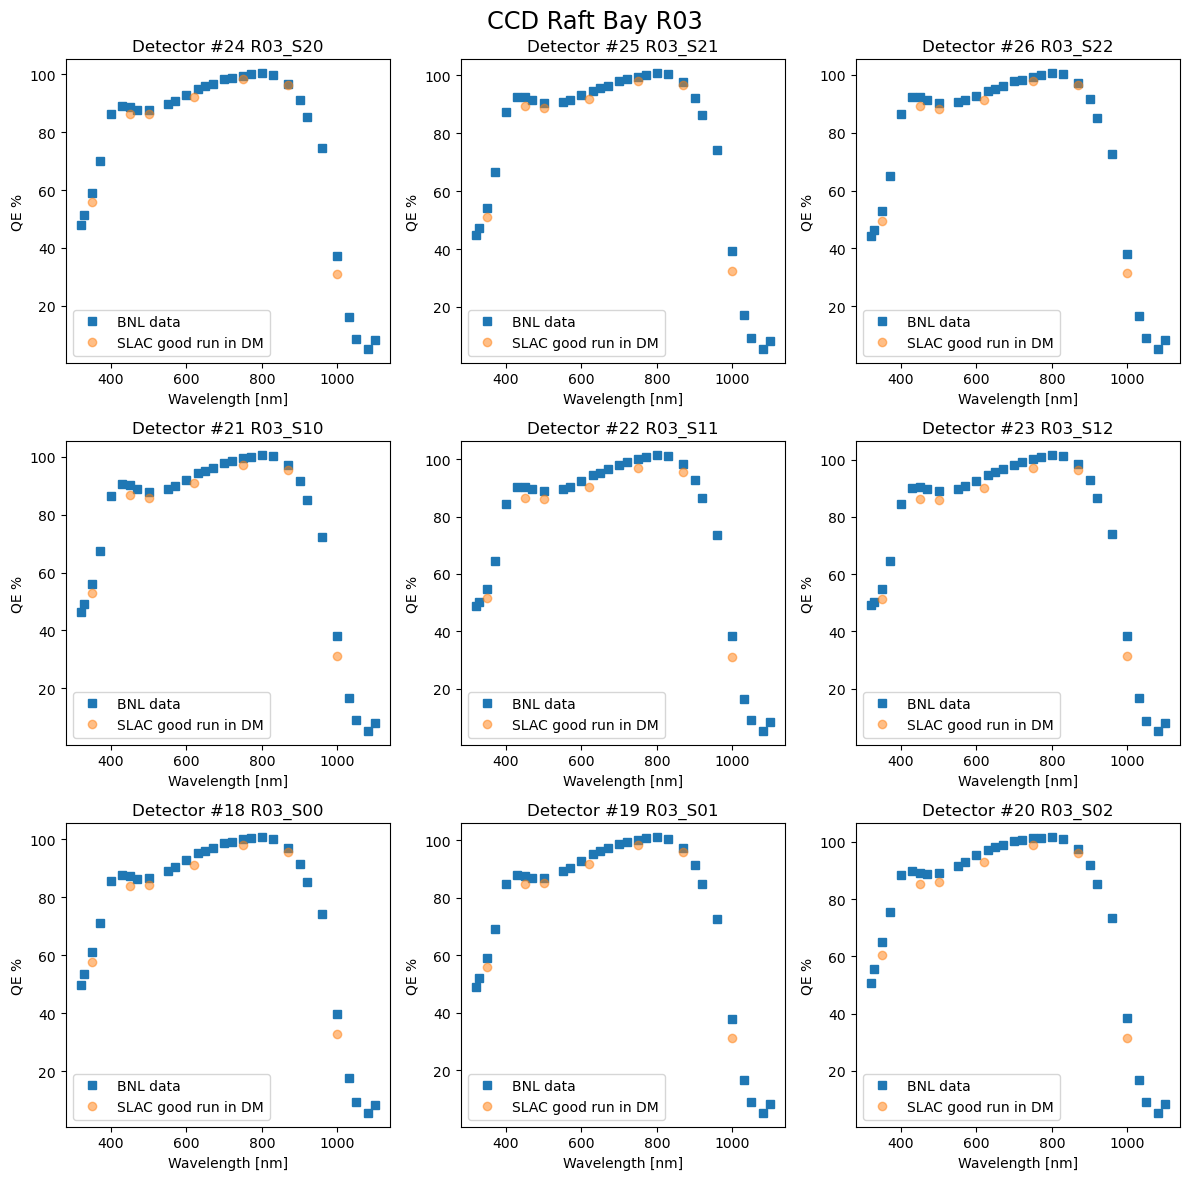

In [72]:
compare_ccd_qe_raft('R03',df_slac,df_dm,label1='BNL data',label2='SLAC good run in DM',plotpoints=True)

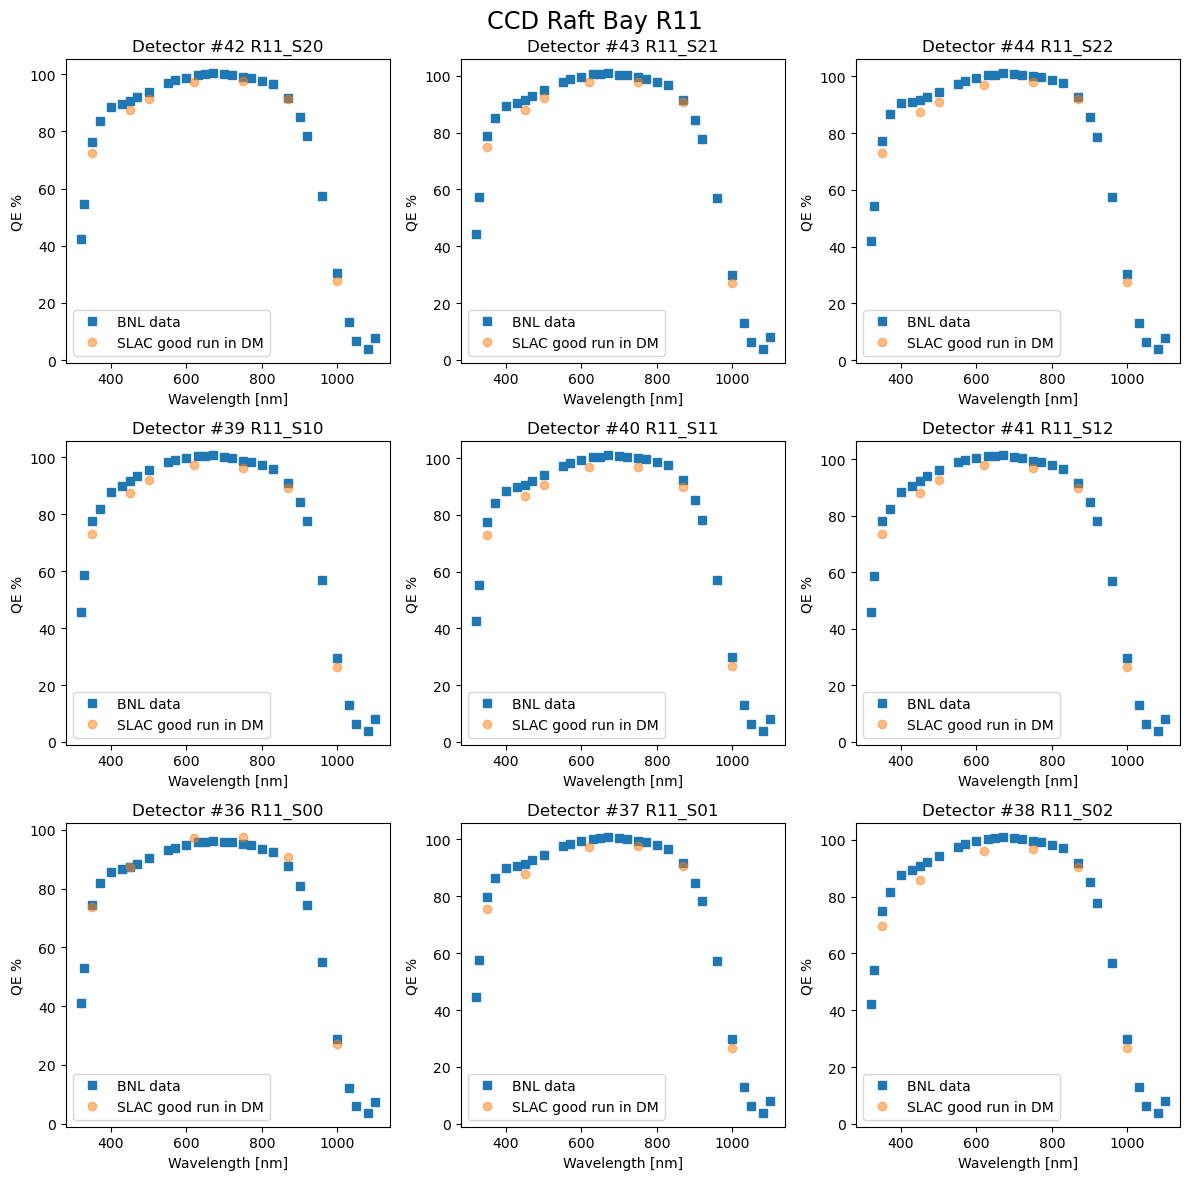

In [73]:
compare_ccd_qe_raft('R11',df_slac,df_dm,label1='BNL data',label2='SLAC good run in DM',plotpoints=True)

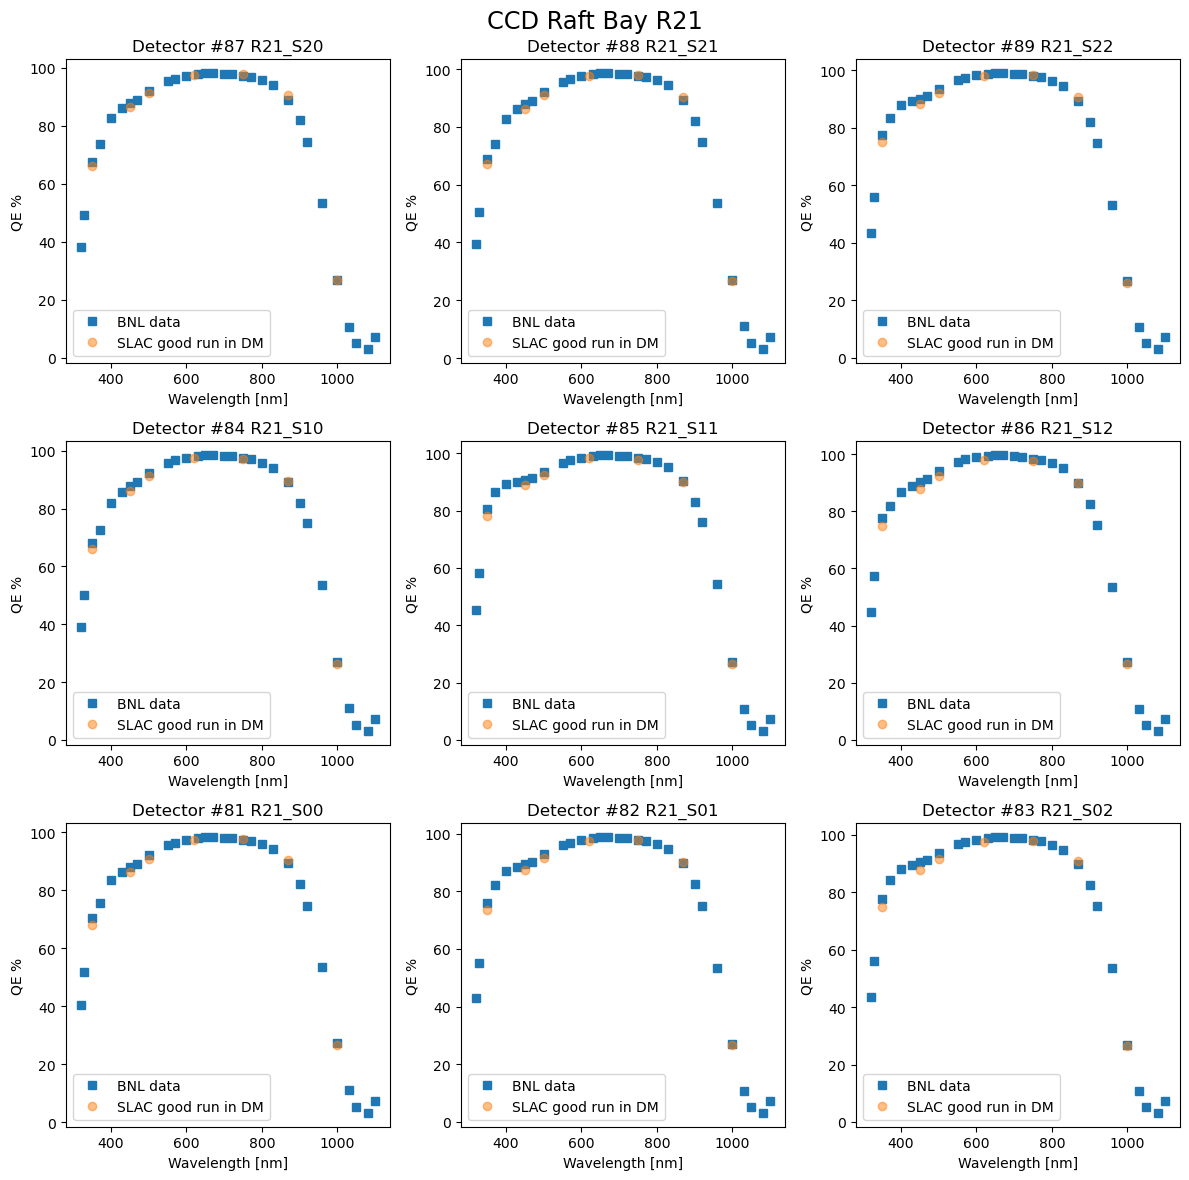

In [74]:
compare_ccd_qe_raft('R21',df_slac,df_dm,label1='BNL data',label2='SLAC good run in DM',plotpoints=True)

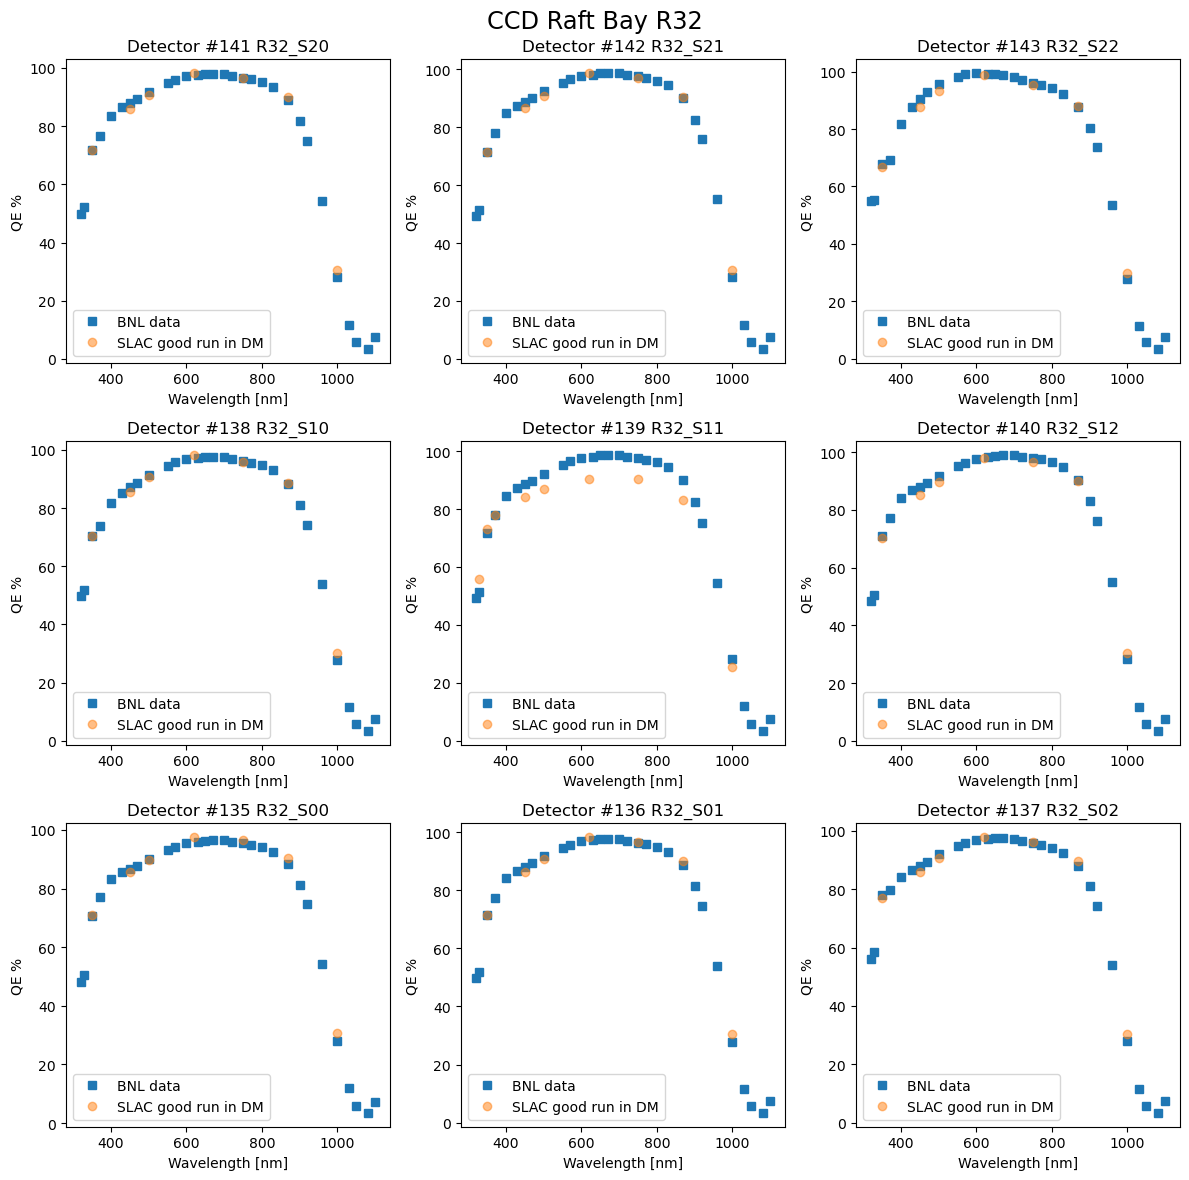

In [75]:
compare_ccd_qe_raft('R32',df_slac,df_dm,label1='BNL data',label2='SLAC good run in DM',plotpoints=True)

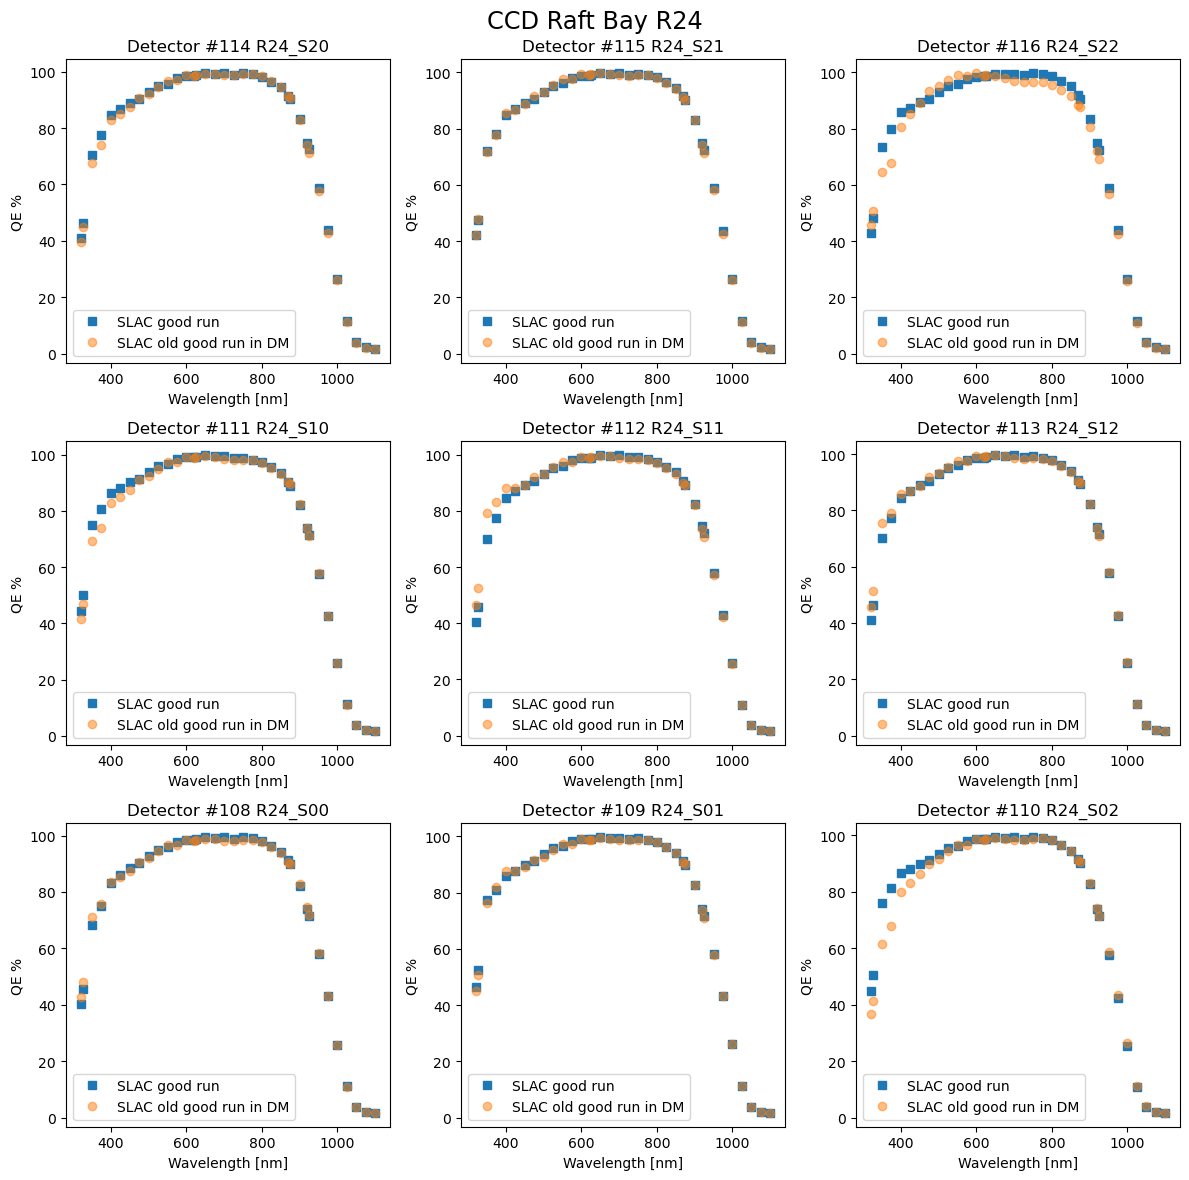

In [76]:
compare_ccd_qe_raft('R24',df_slac,df_dm,label1='SLAC good run',label2='SLAC old good run in DM',plotpoints=True)

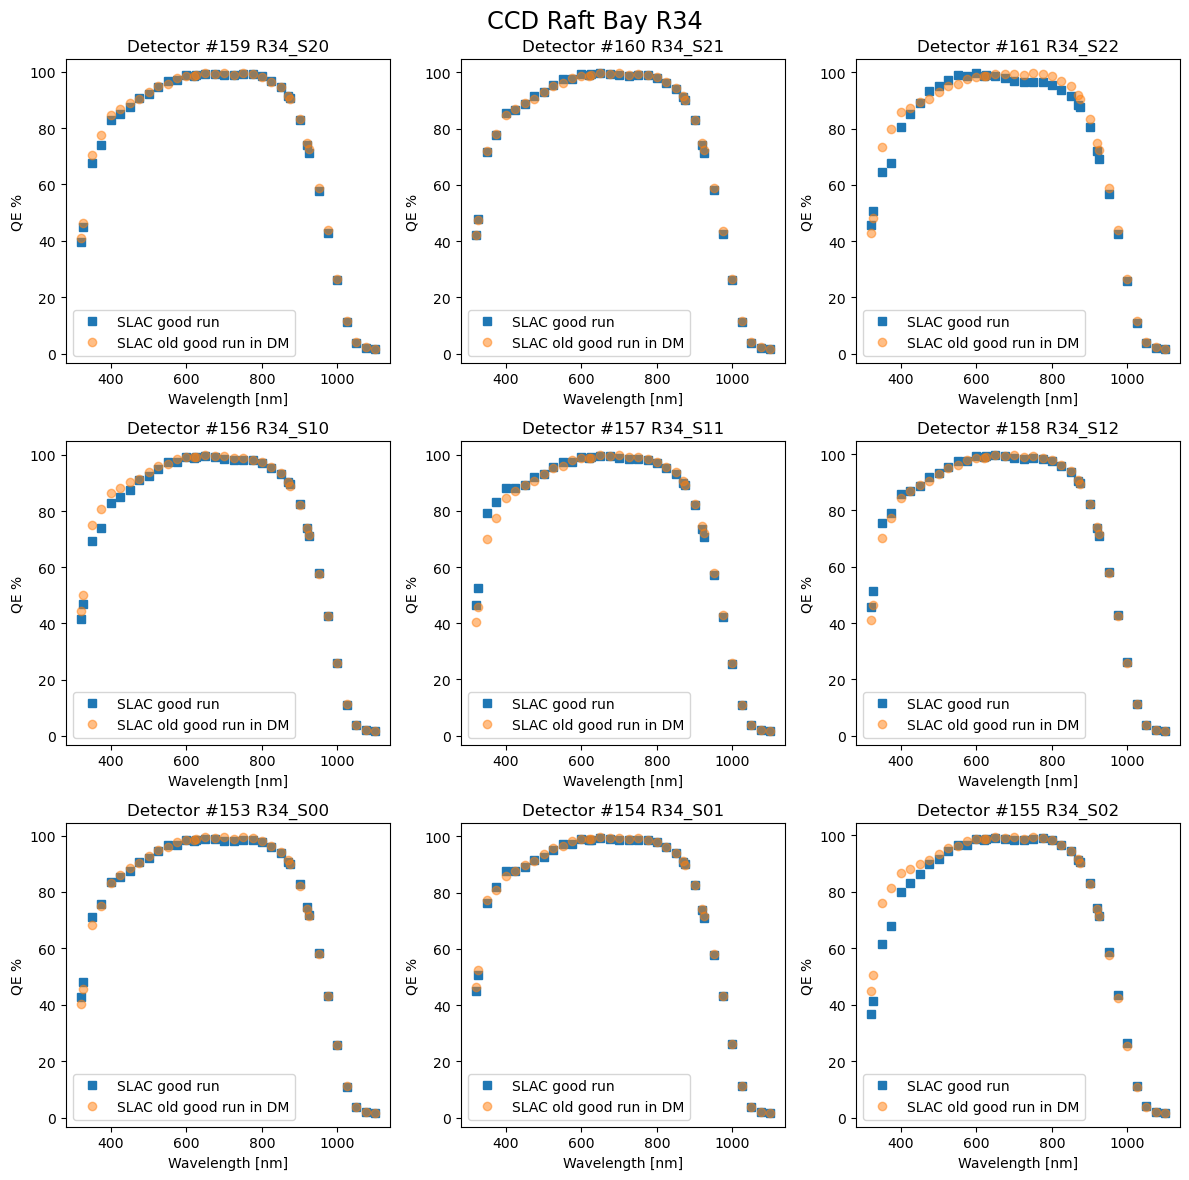

In [77]:
compare_ccd_qe_raft('R34',df_slac,df_dm,label1='SLAC good run',label2='SLAC old good run in DM',plotpoints=True)

# run to catch all changed  QE values

18 R03_S00
19 R03_S01
20 R03_S02
21 R03_S10
22 R03_S11
23 R03_S12
24 R03_S20
25 R03_S21
26 R03_S22
36 R11_S00
37 R11_S01
38 R11_S02
39 R11_S10
40 R11_S11
41 R11_S12
42 R11_S20
43 R11_S21
44 R11_S22
81 R21_S00
82 R21_S01
83 R21_S02
84 R21_S10
85 R21_S11
86 R21_S12
87 R21_S20
88 R21_S21


/tmp/ipykernel_25824/3841242413.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f,ax = plt.subplots(1,2,figsize=(12,6))


89 R21_S22
108 R24_S00
109 R24_S01
110 R24_S02
111 R24_S10
112 R24_S11
113 R24_S12
114 R24_S20
115 R24_S21
116 R24_S22
Fix nans at idet= 117
117 R30_S00
135 R32_S00
136 R32_S01
137 R32_S02
138 R32_S10
139 R32_S11
140 R32_S12
141 R32_S20
142 R32_S21
143 R32_S22
153 R34_S00
154 R34_S01
155 R34_S02
156 R34_S10
157 R34_S11
158 R34_S12
159 R34_S20
160 R34_S21
161 R34_S22


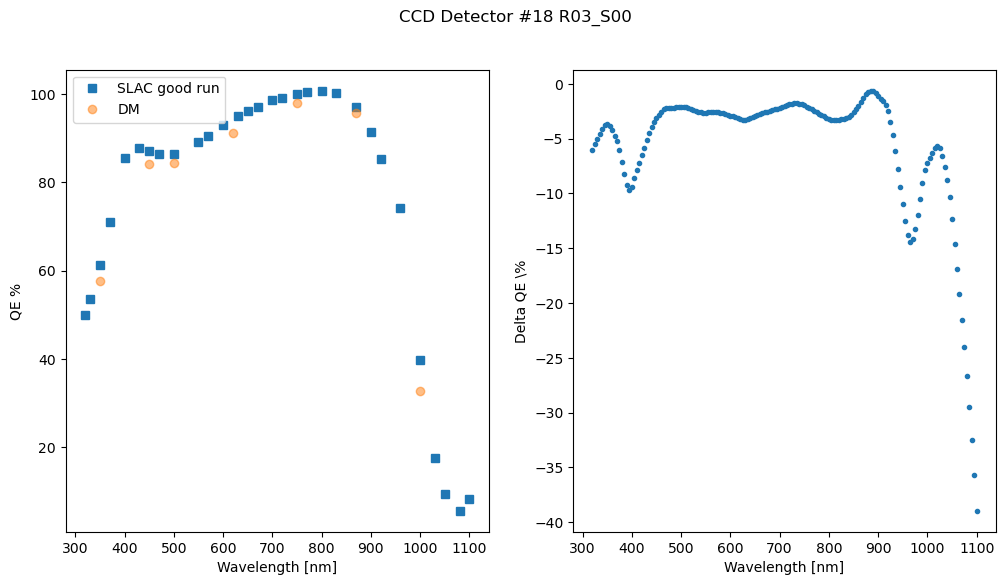

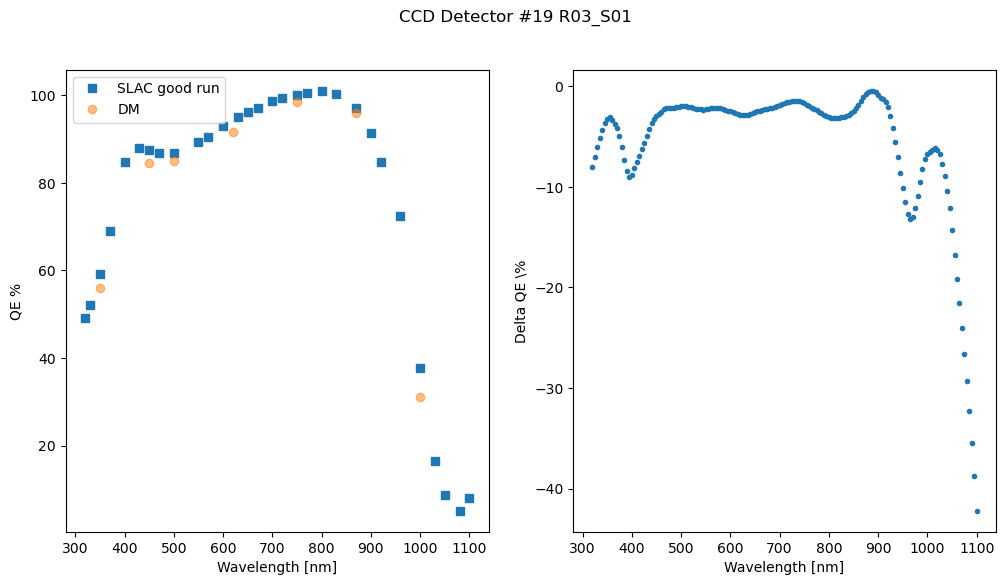

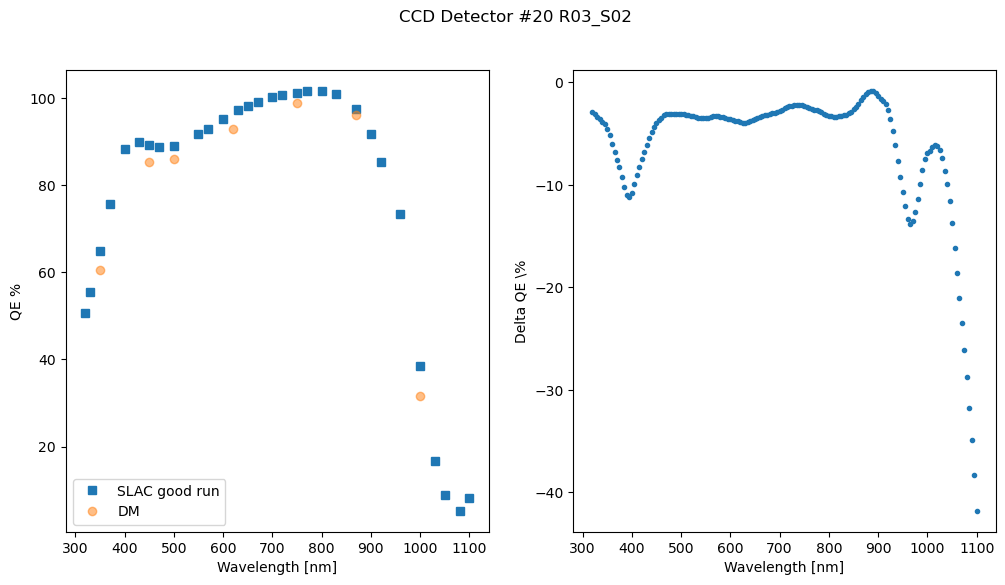

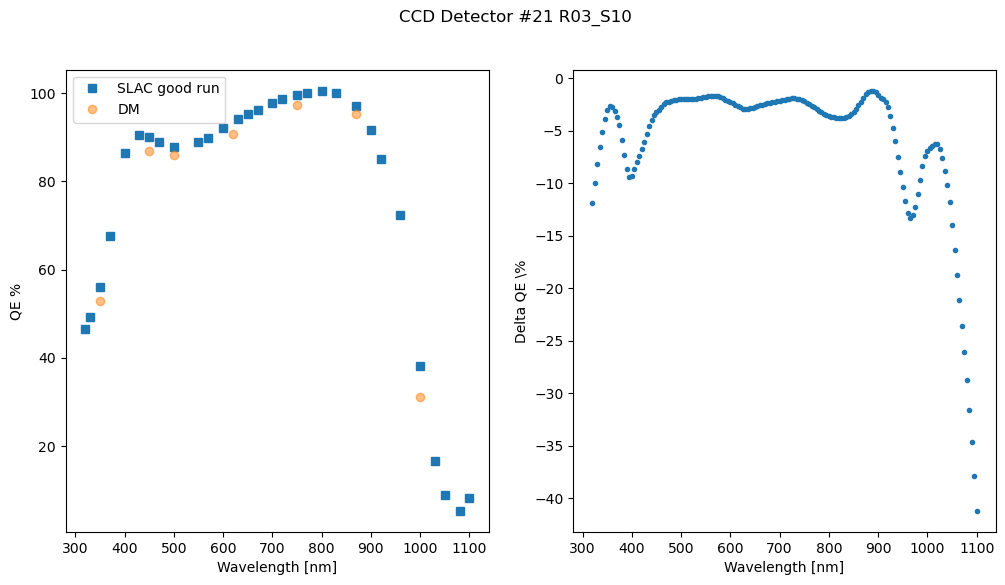

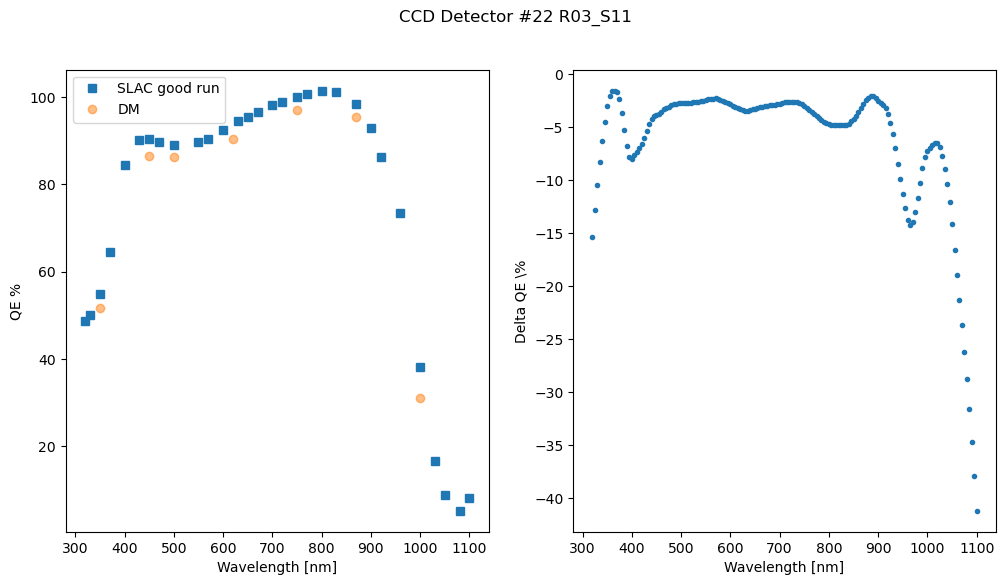

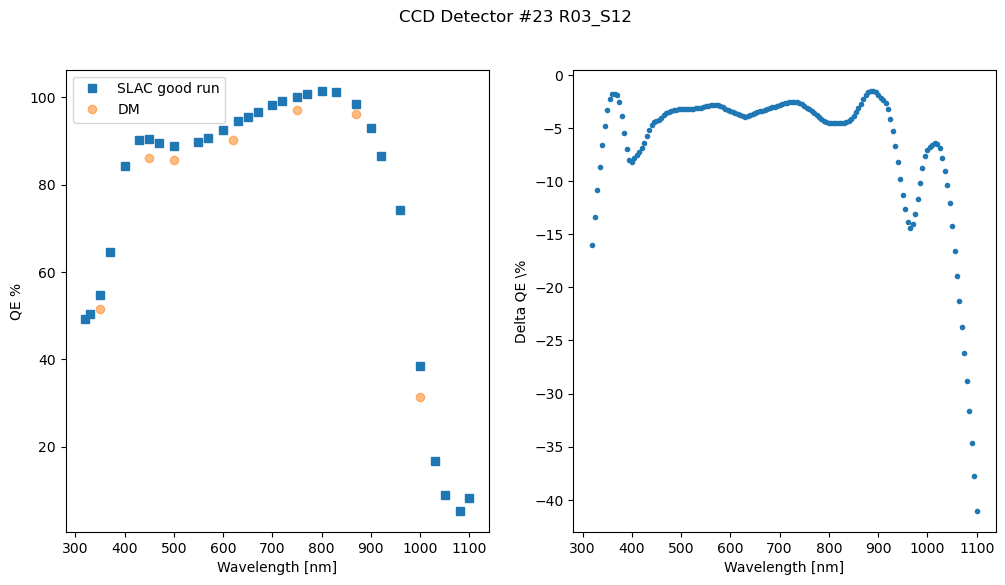

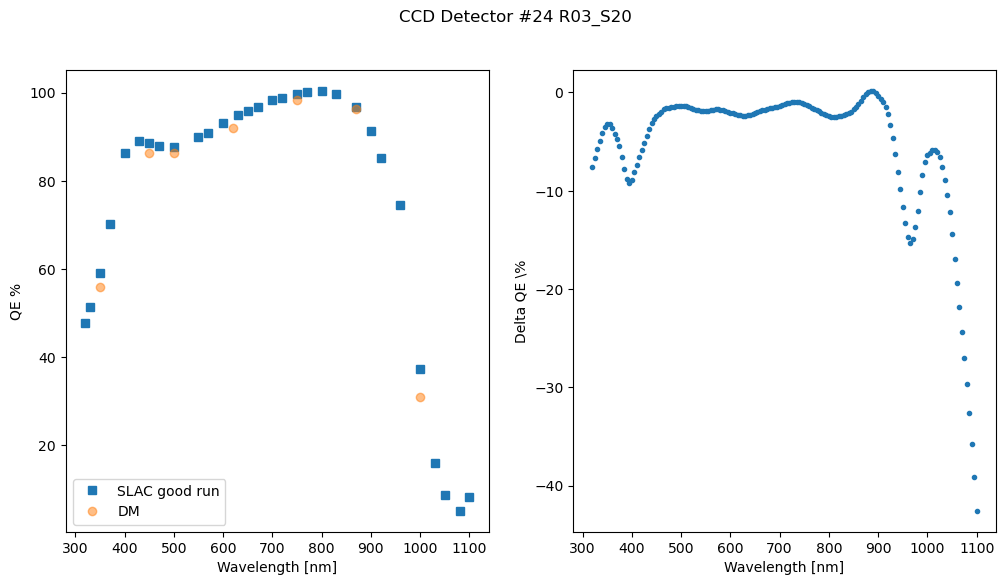

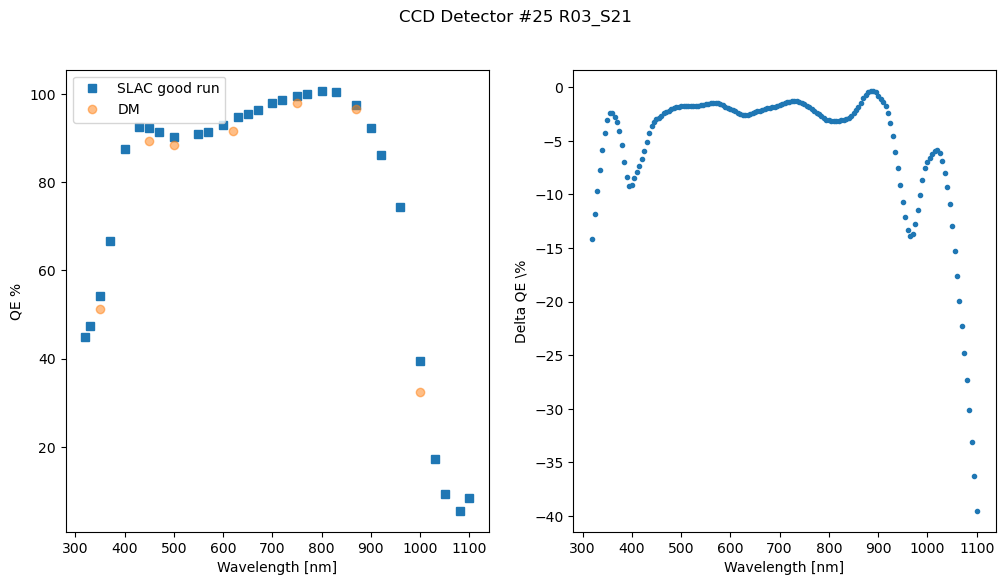

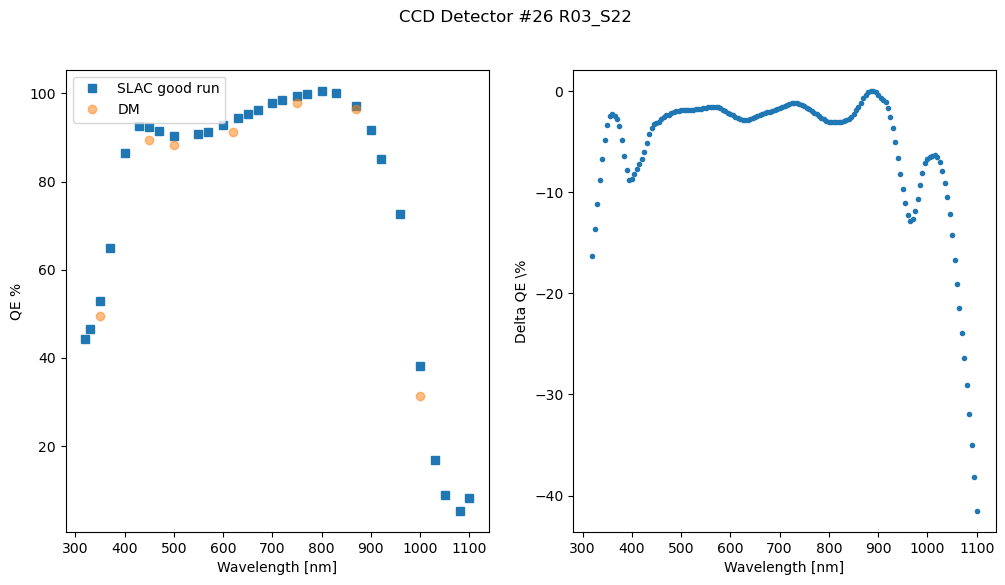

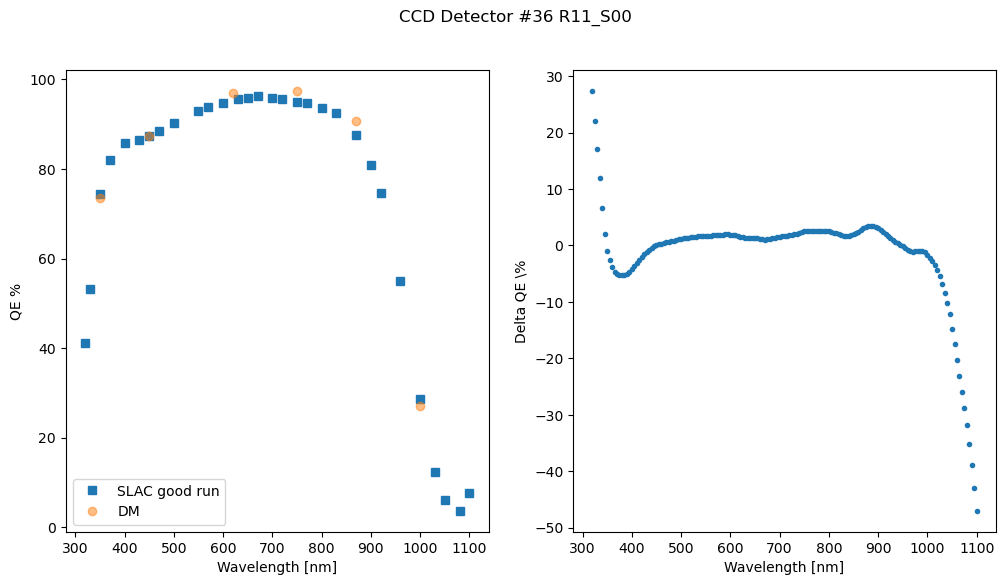

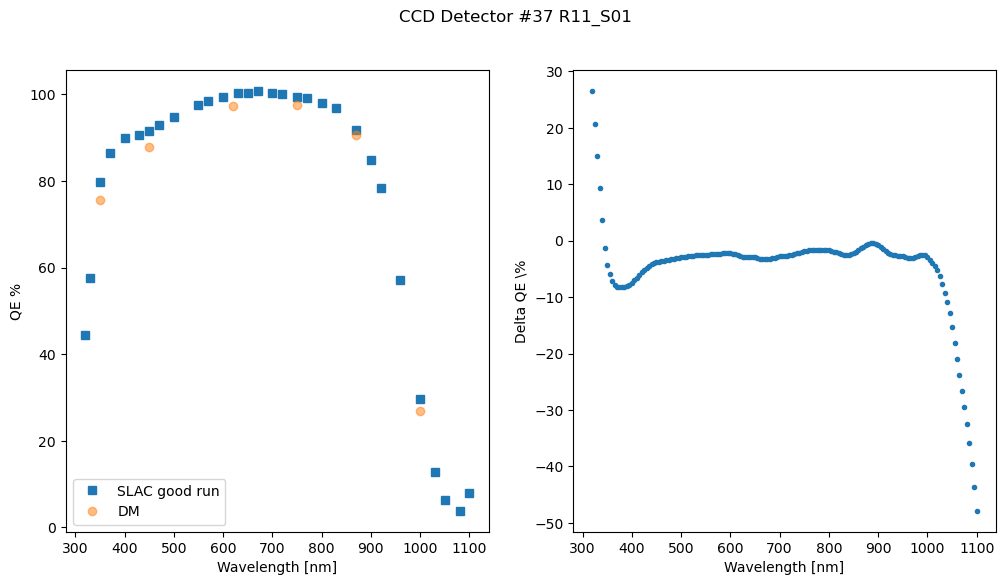

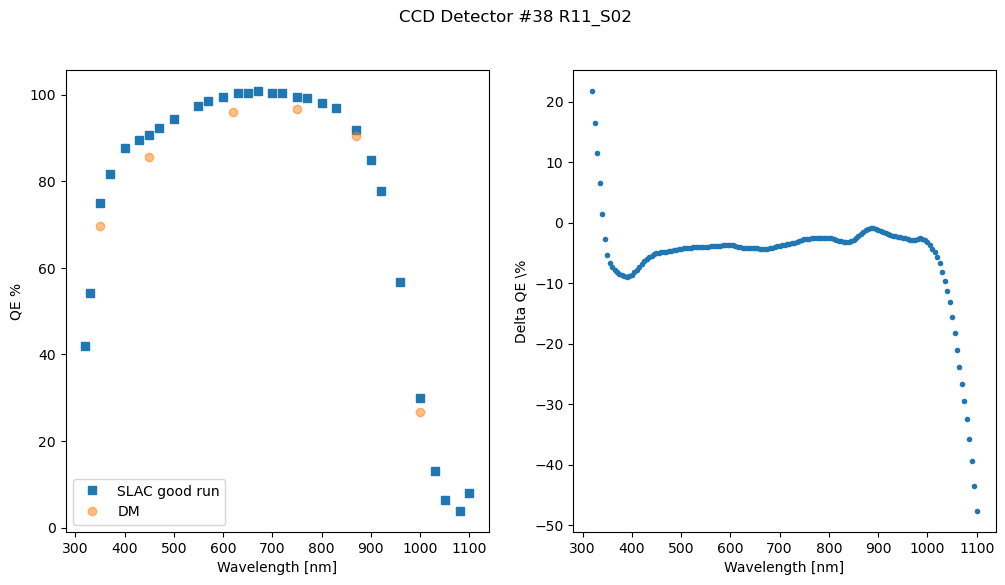

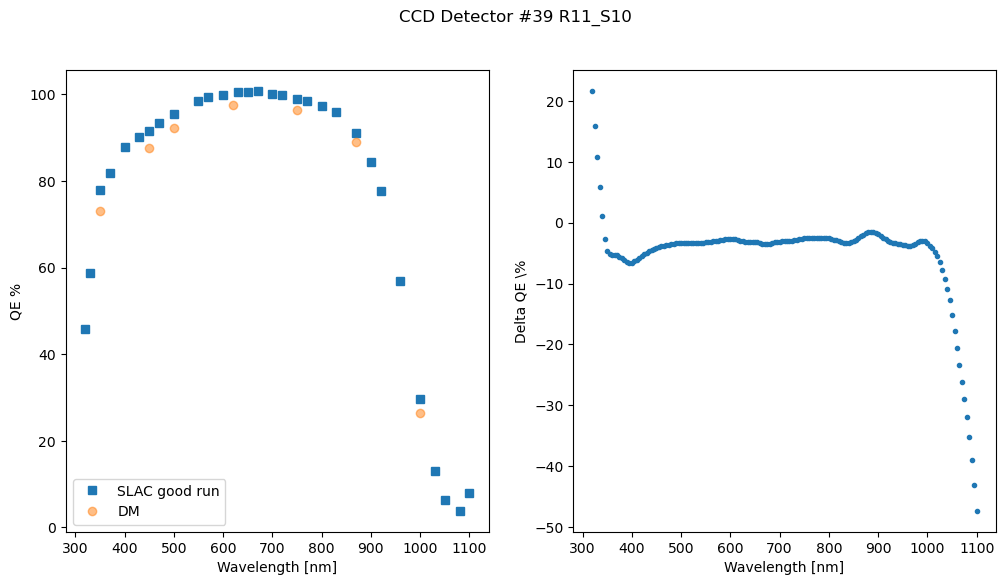

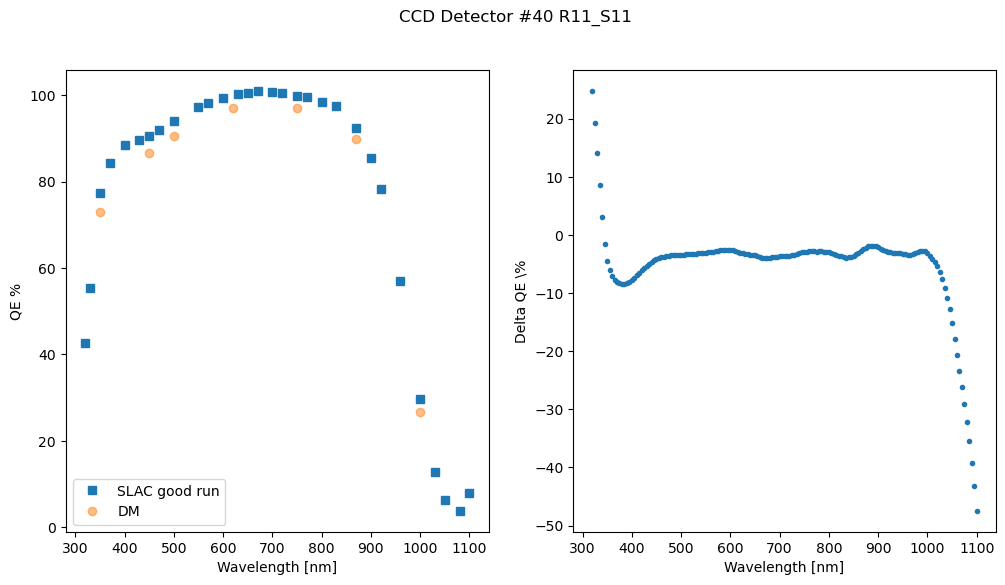

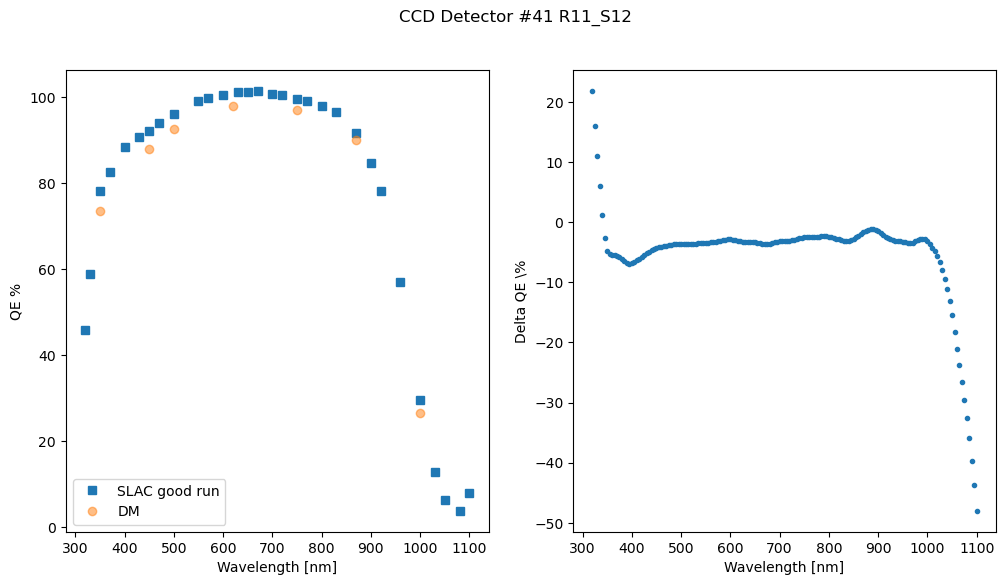

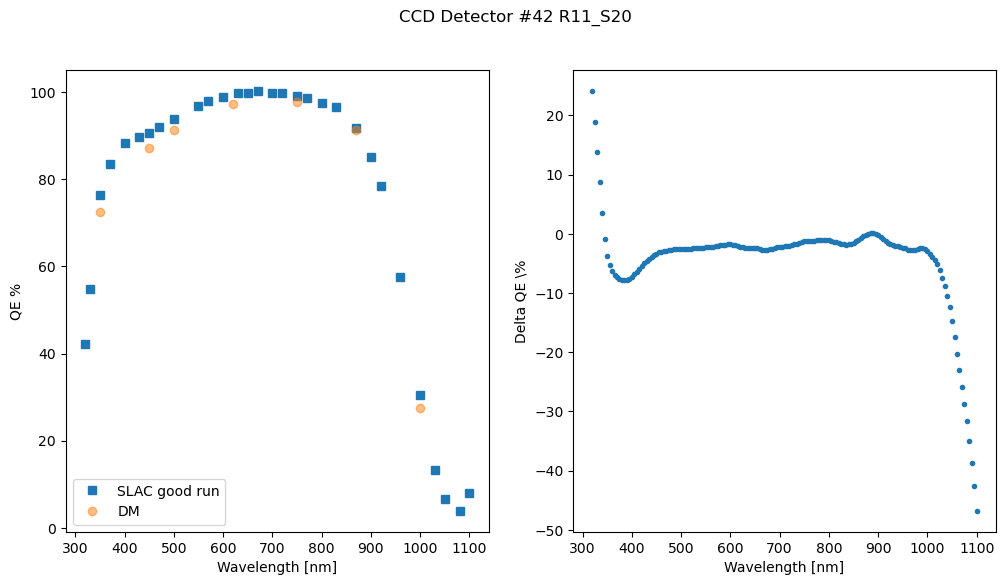

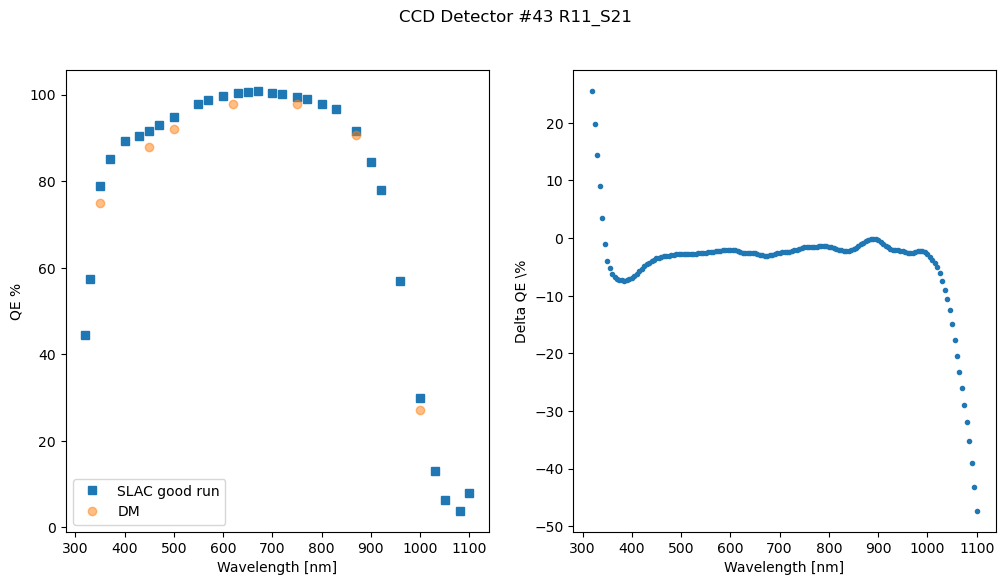

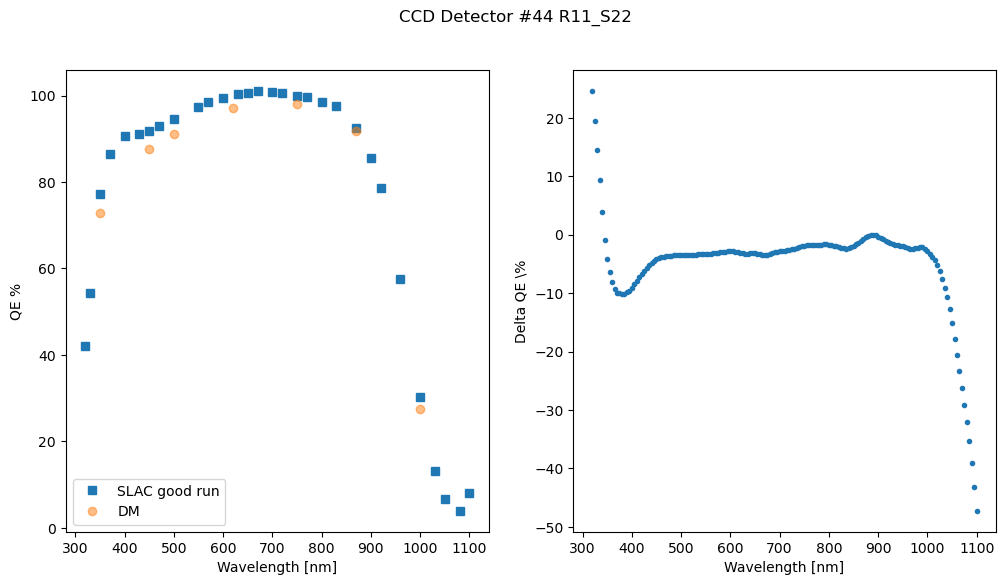

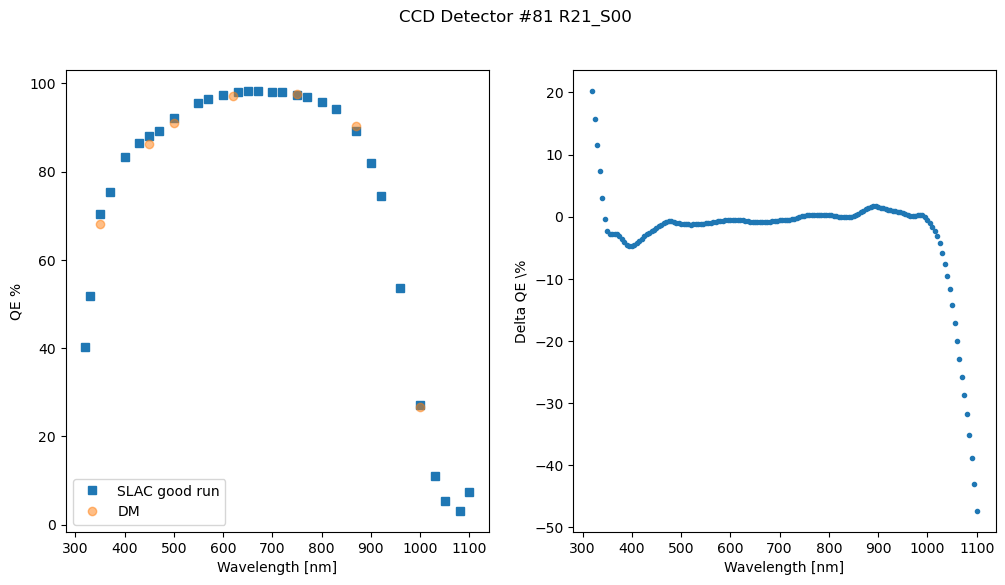

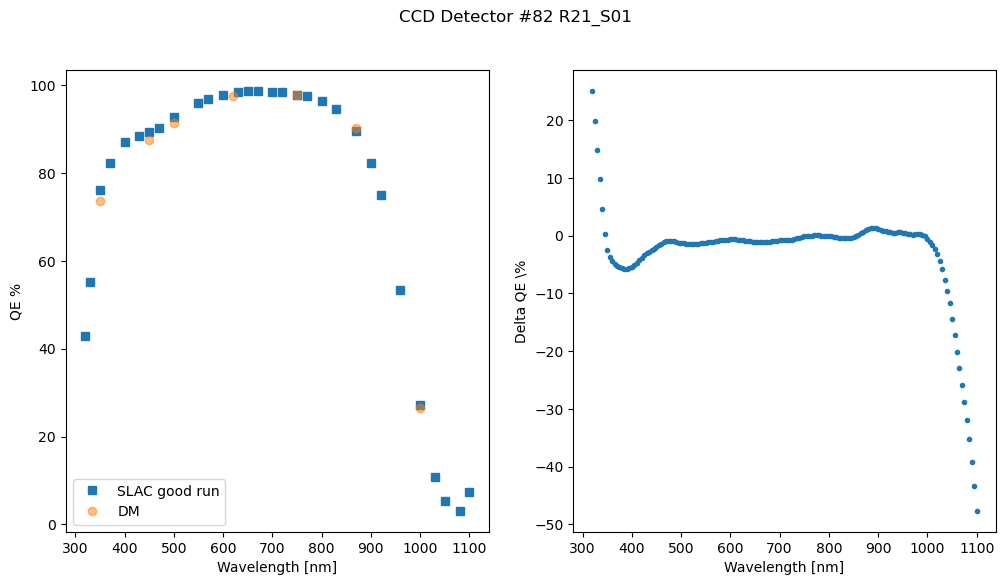

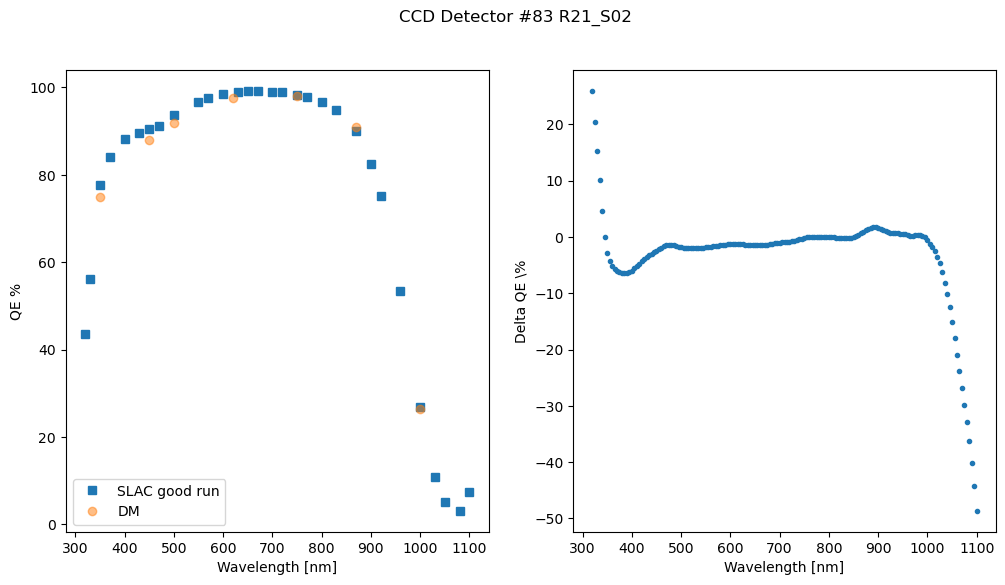

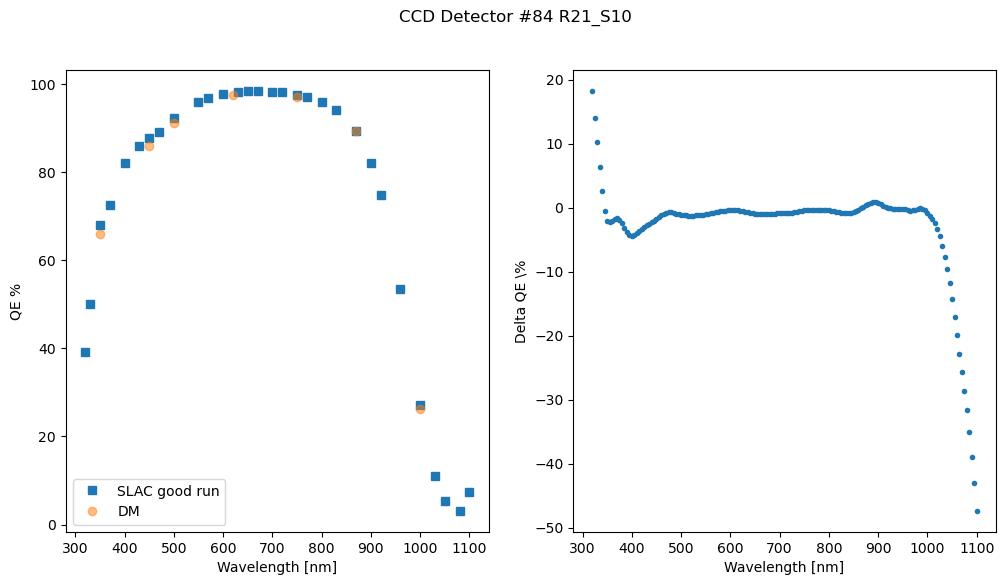

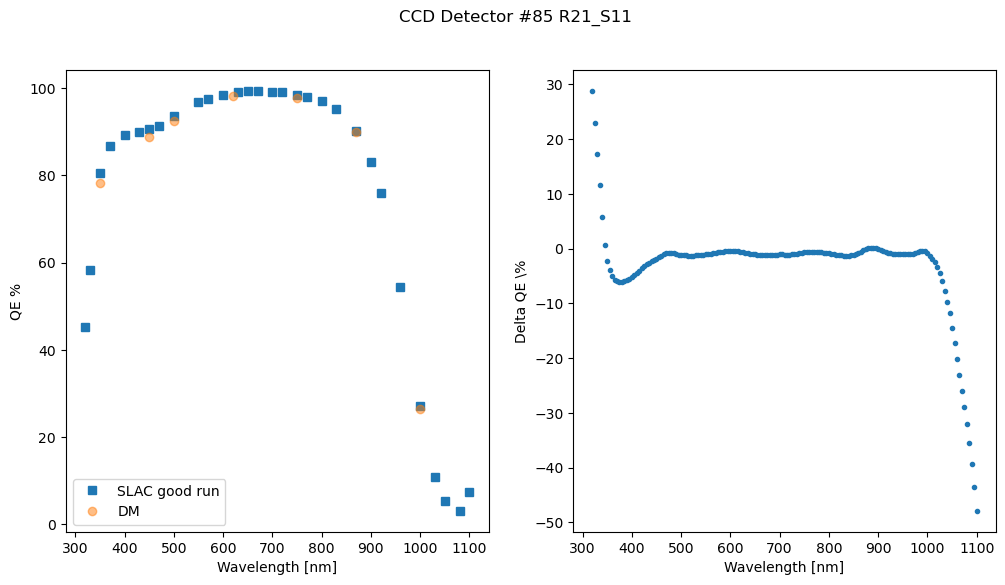

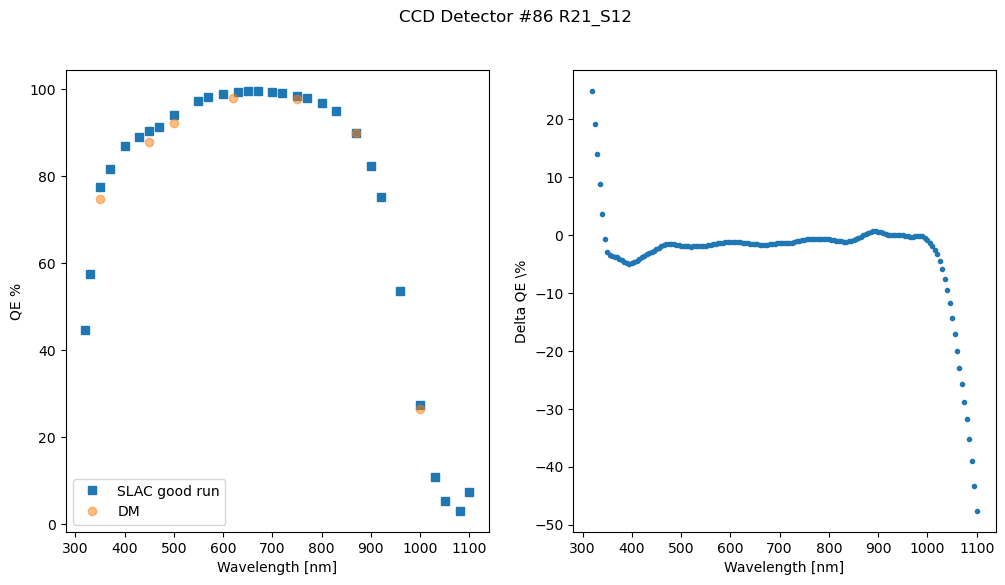

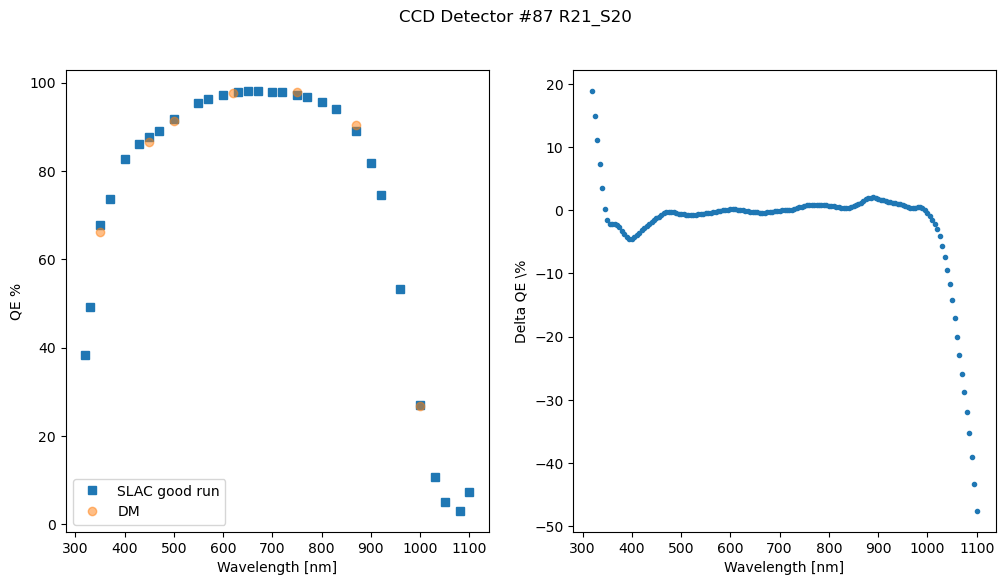

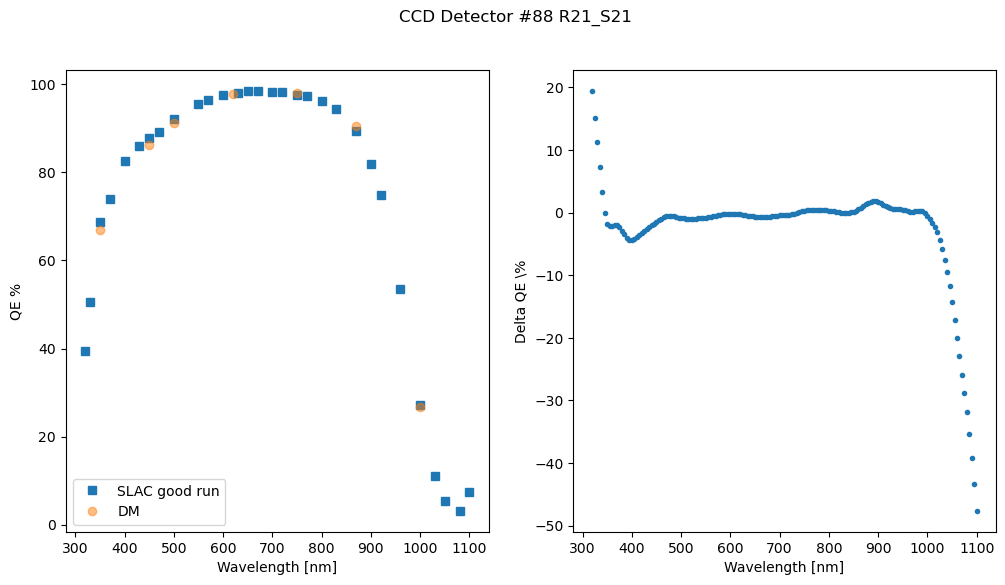

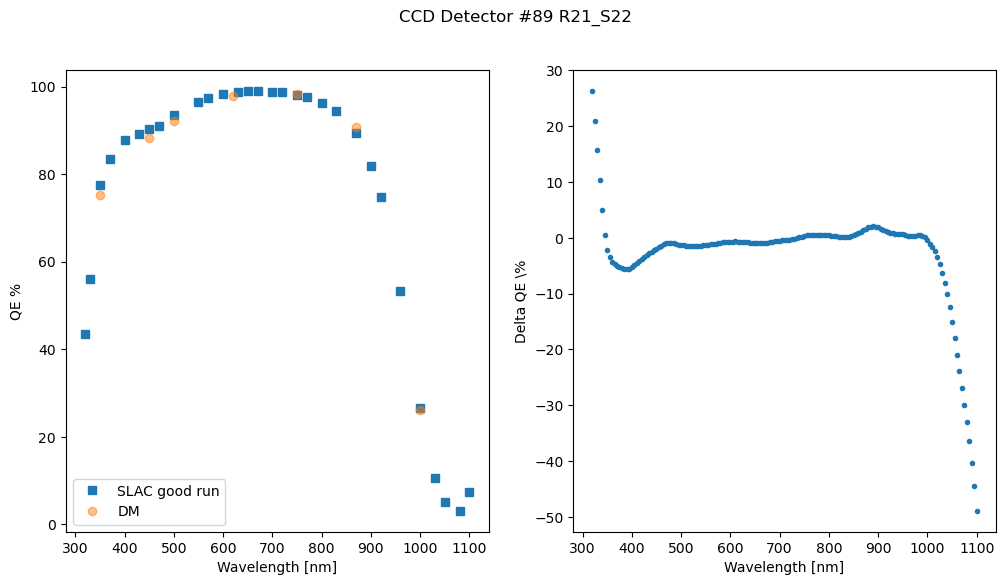

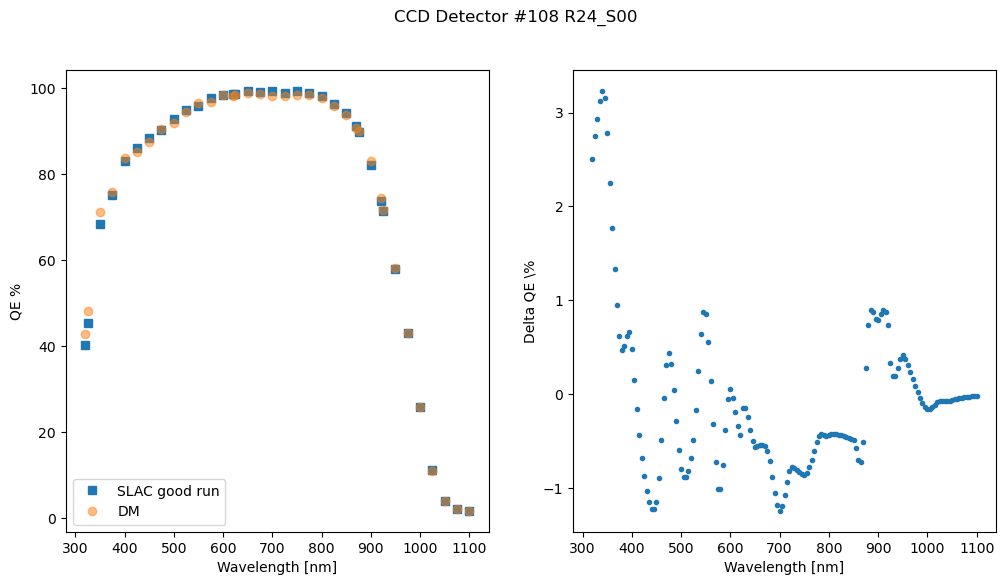

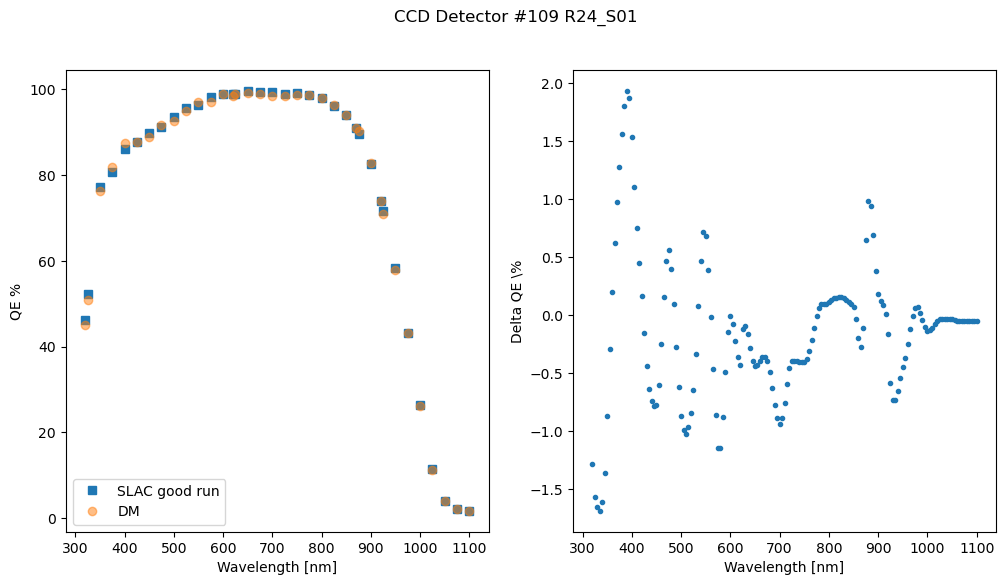

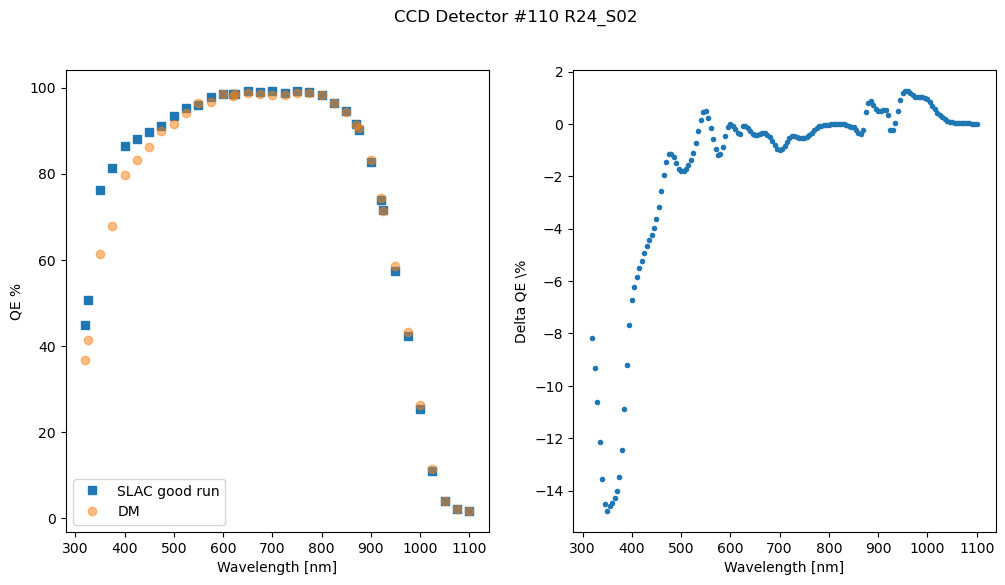

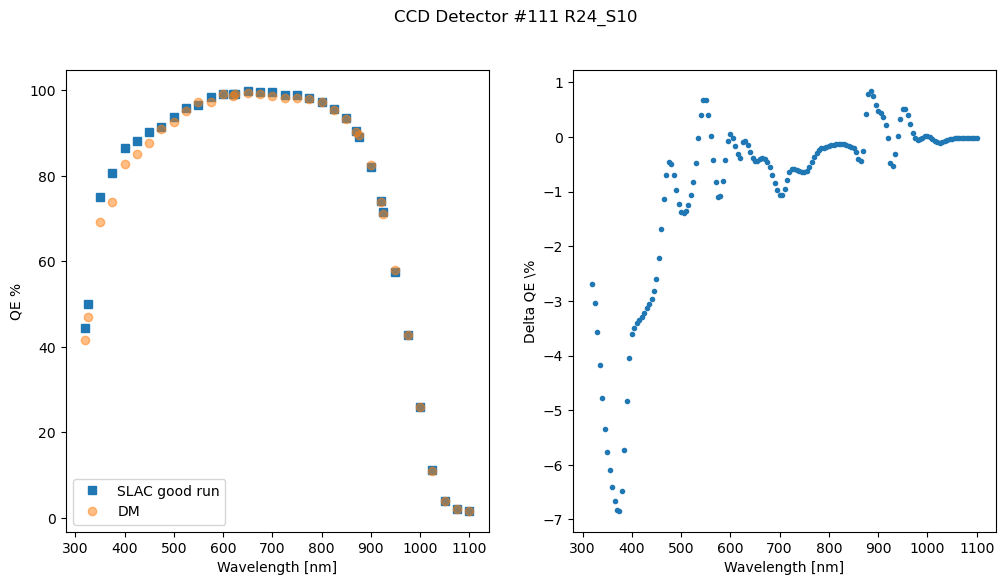

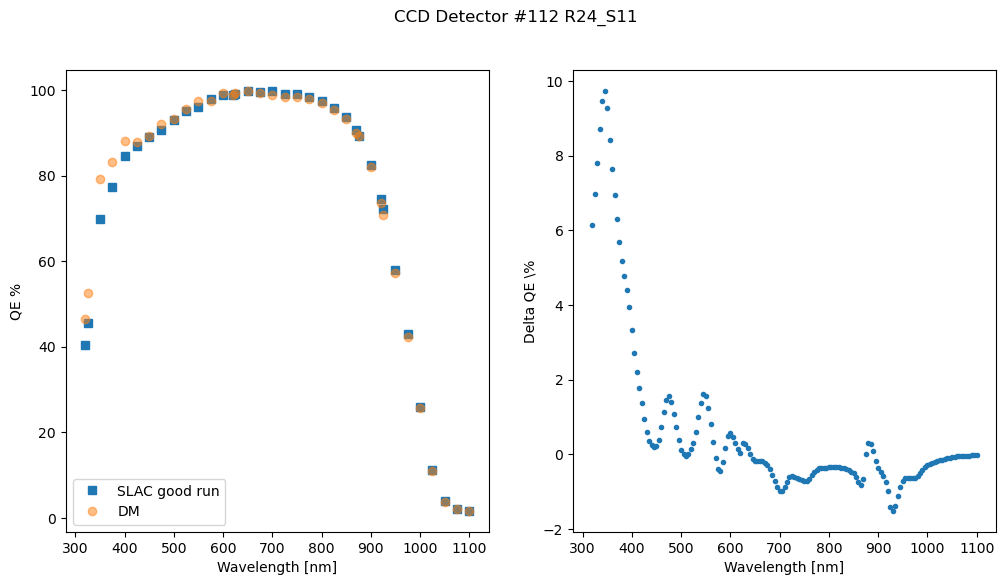

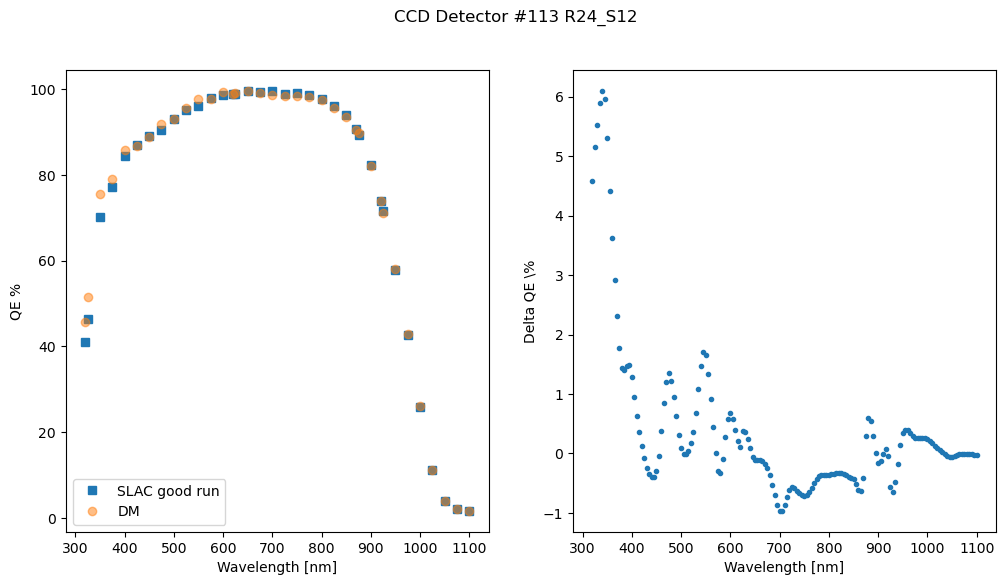

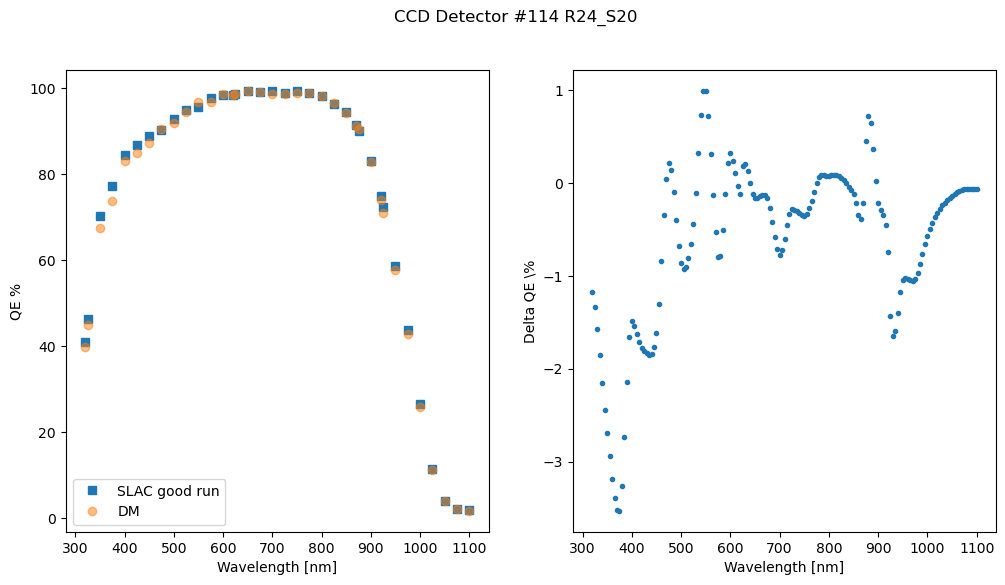

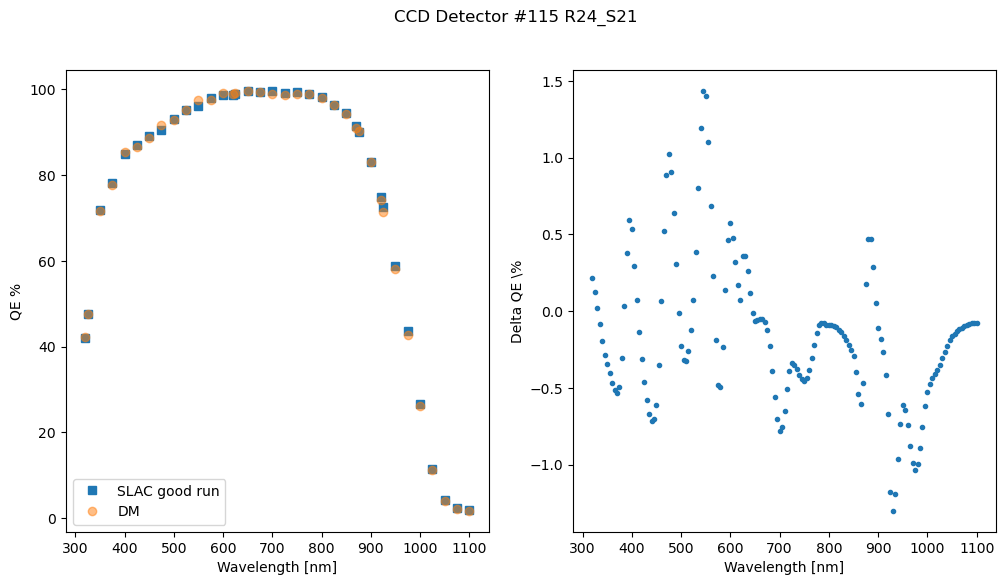

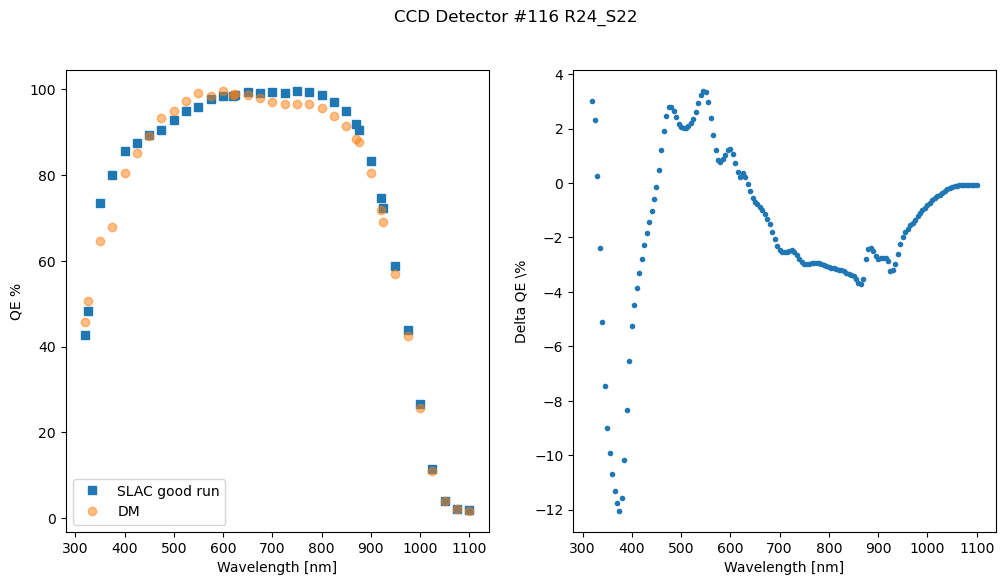

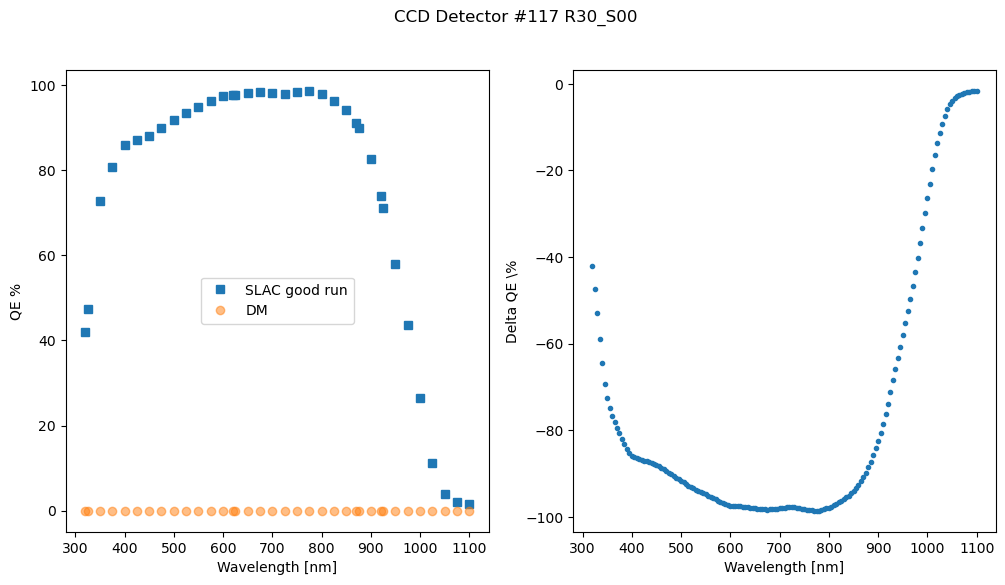

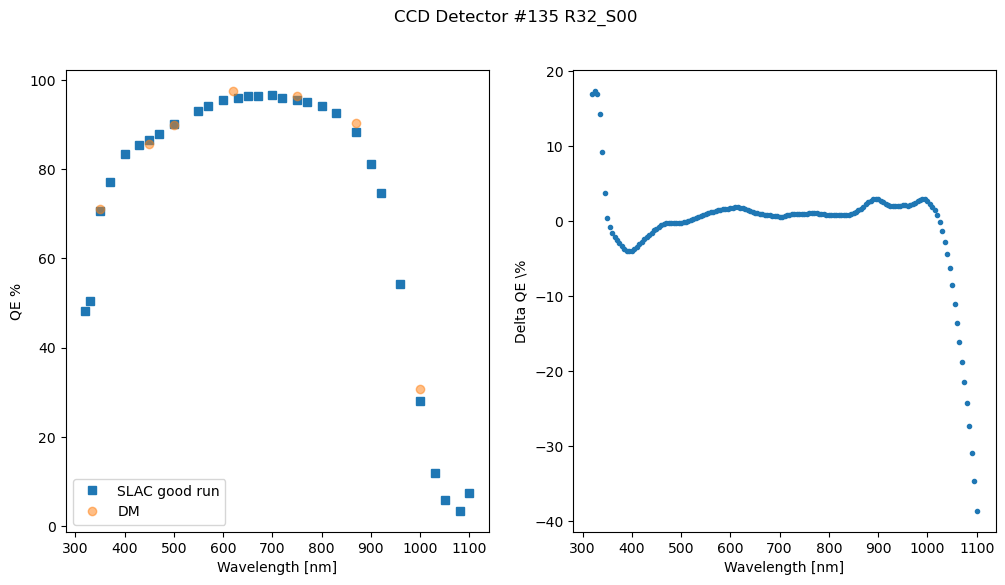

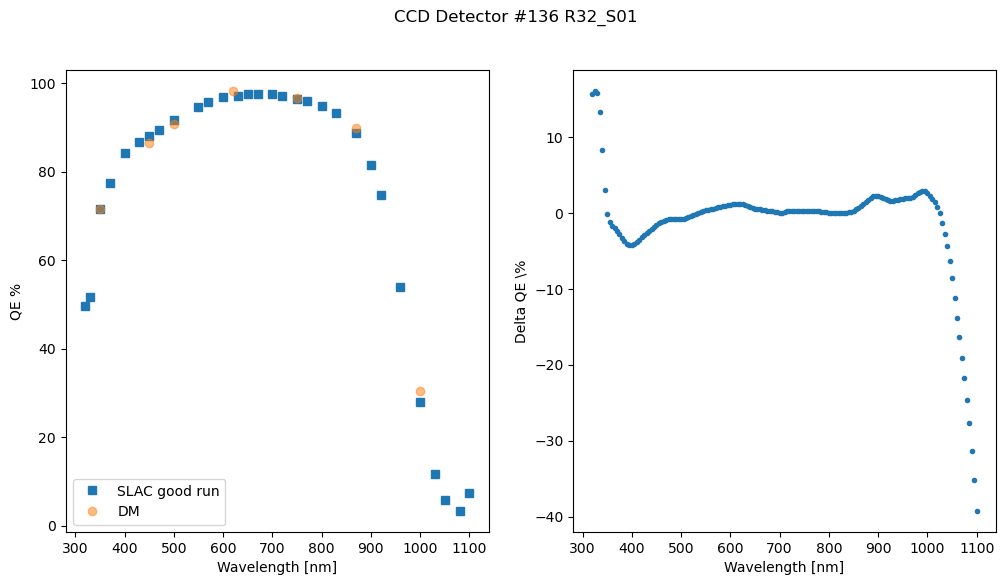

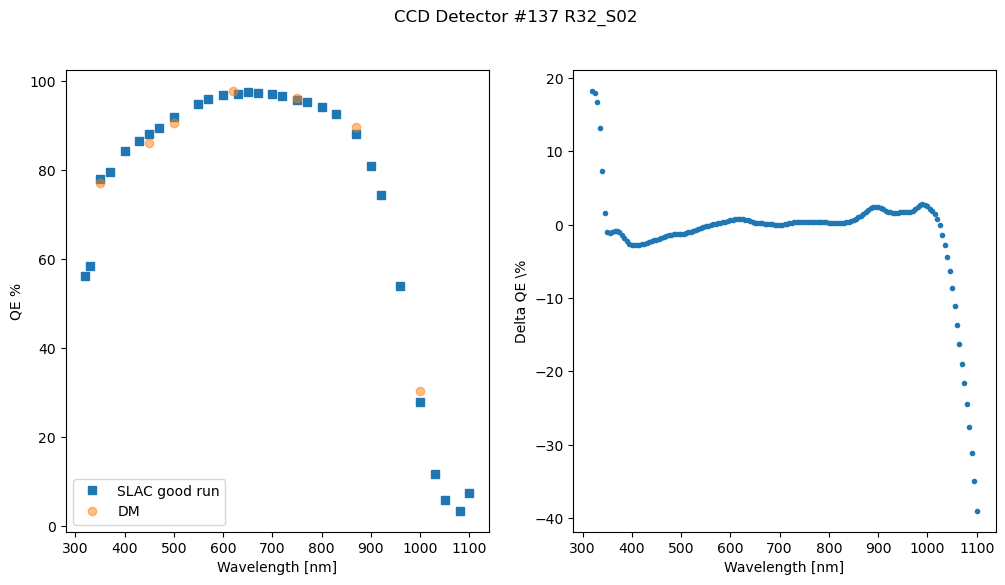

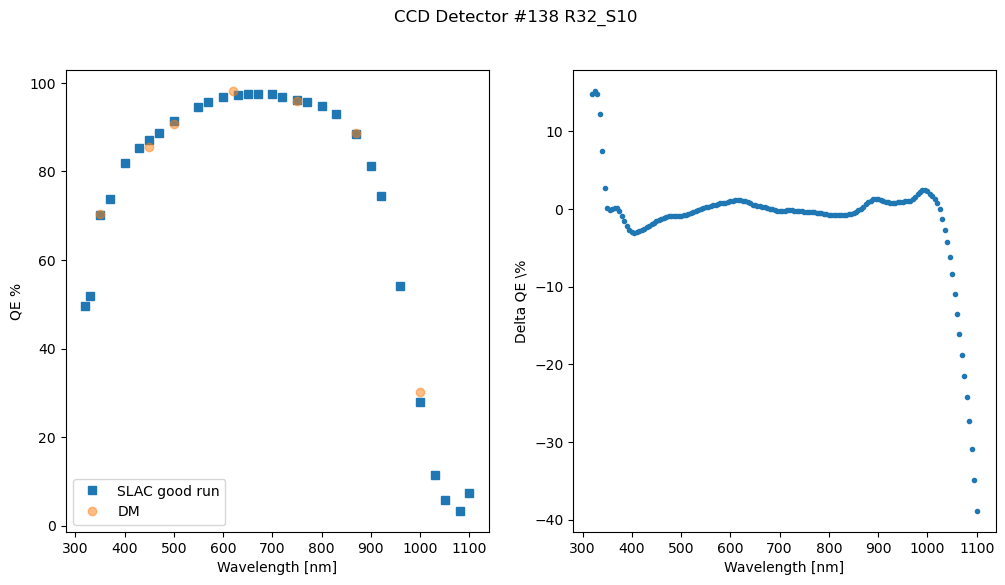

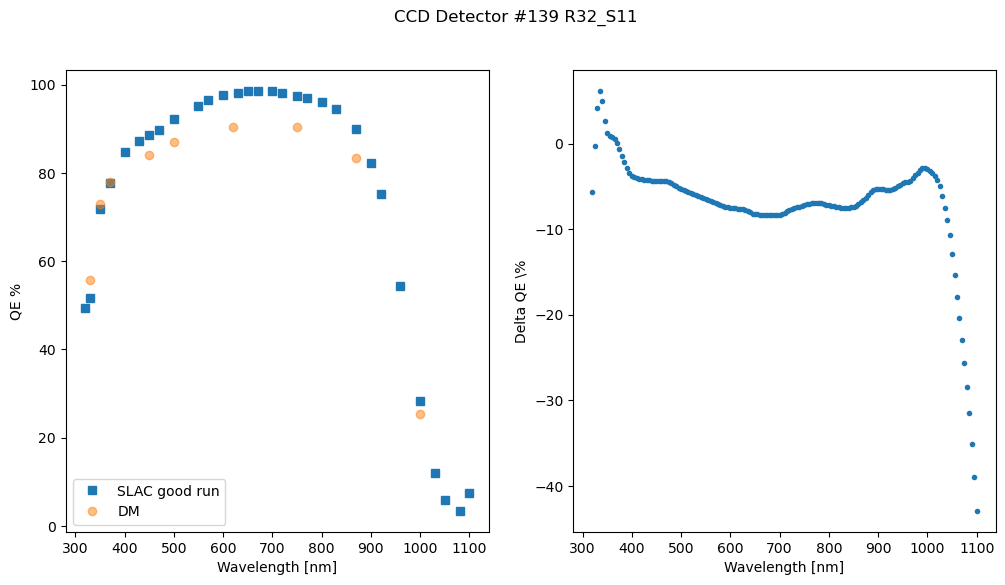

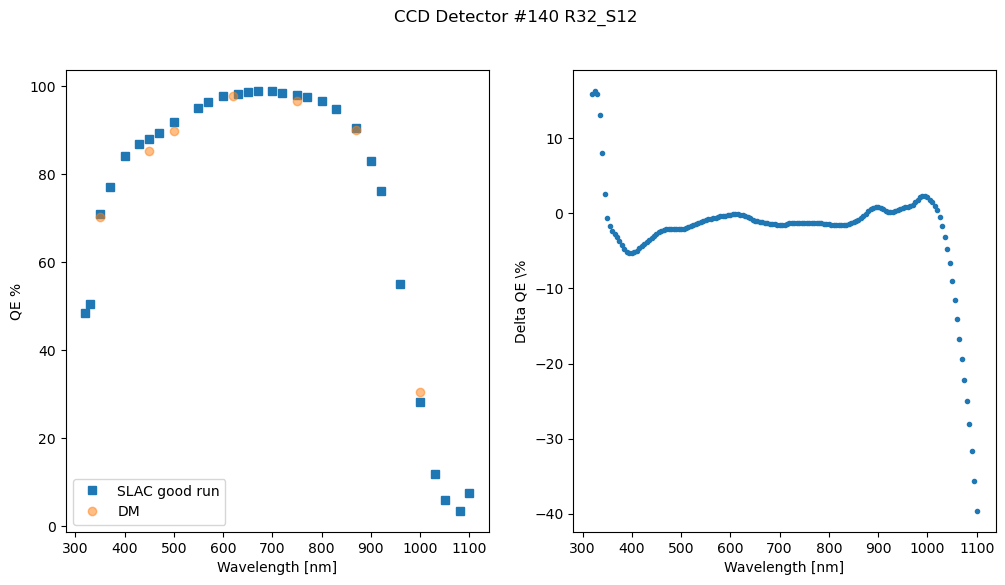

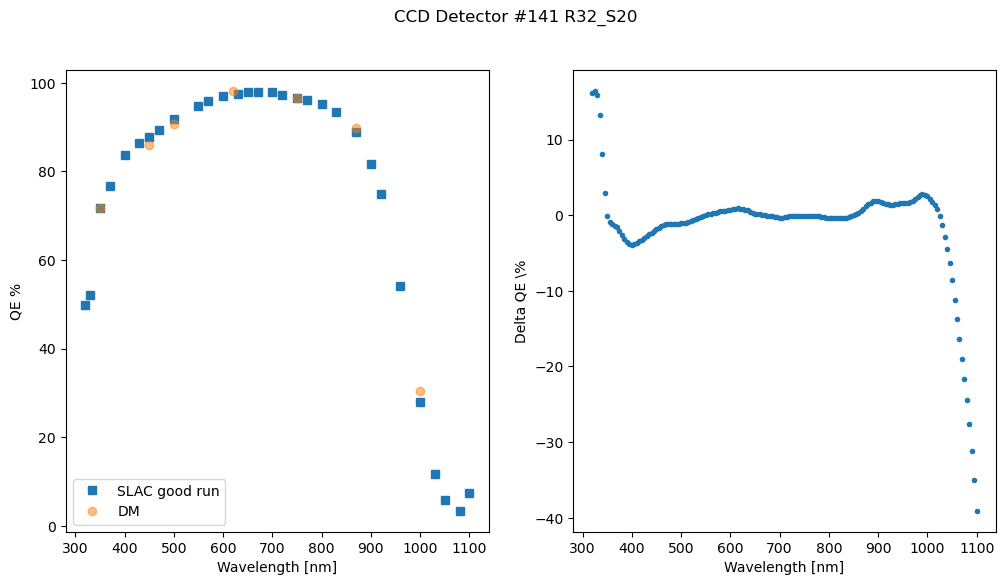

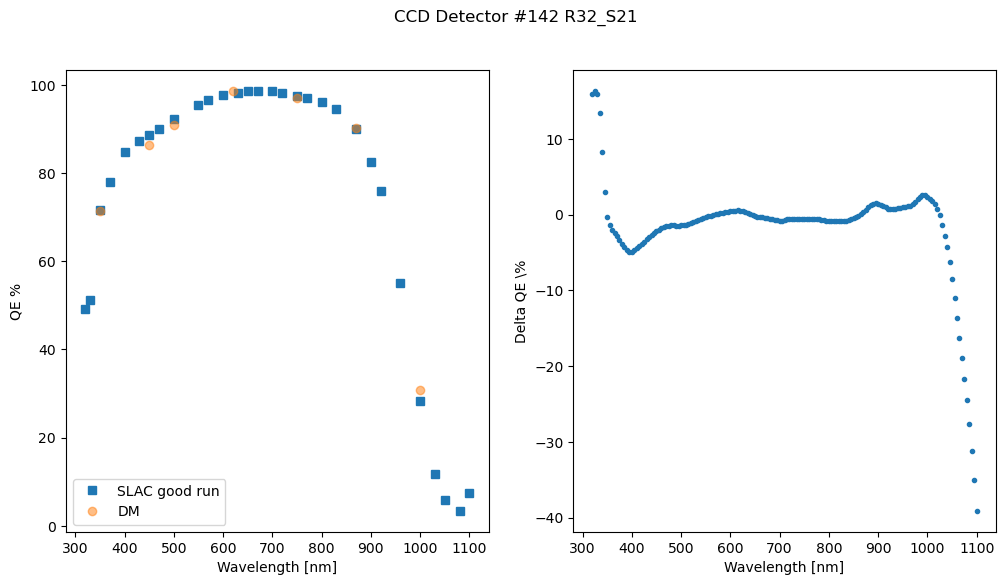

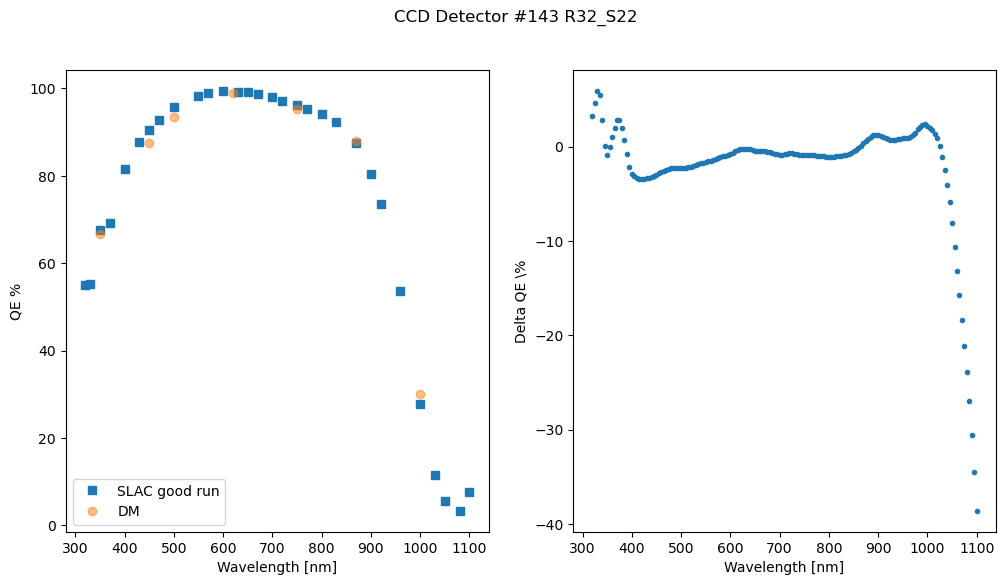

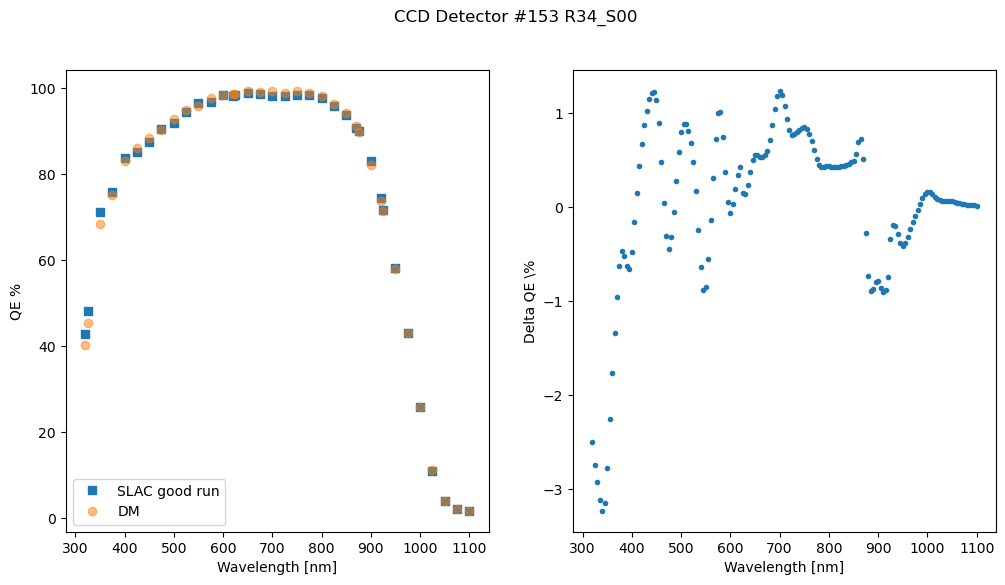

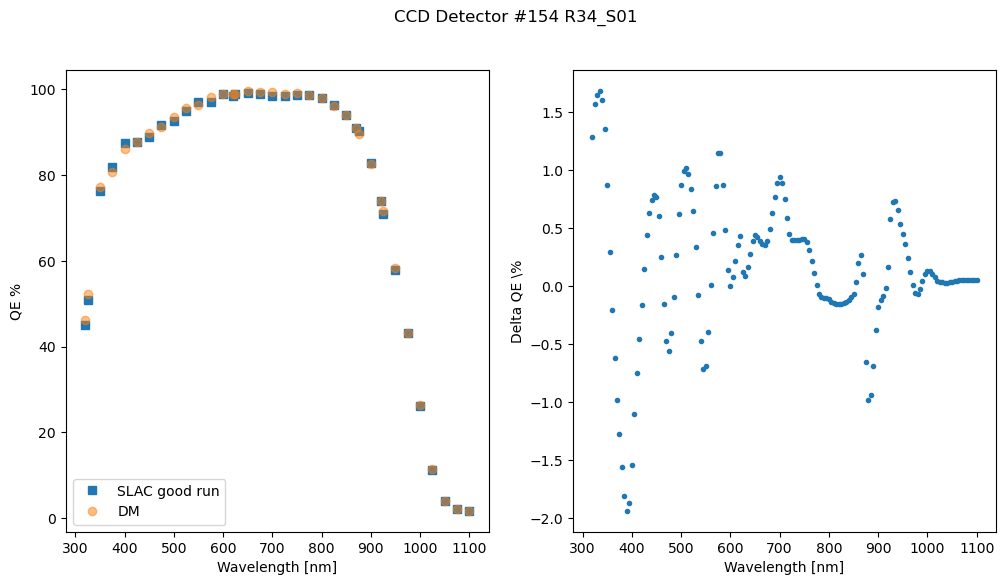

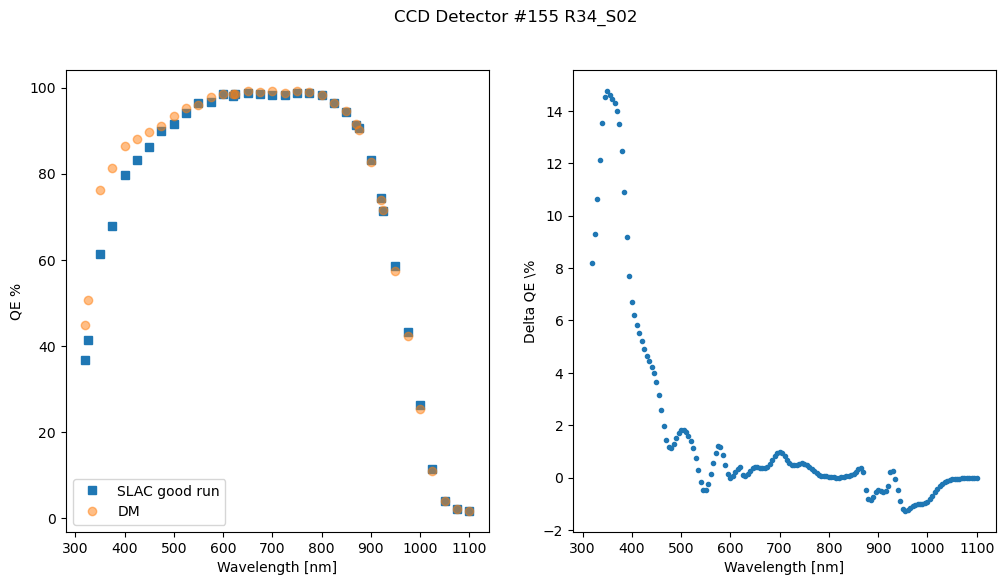

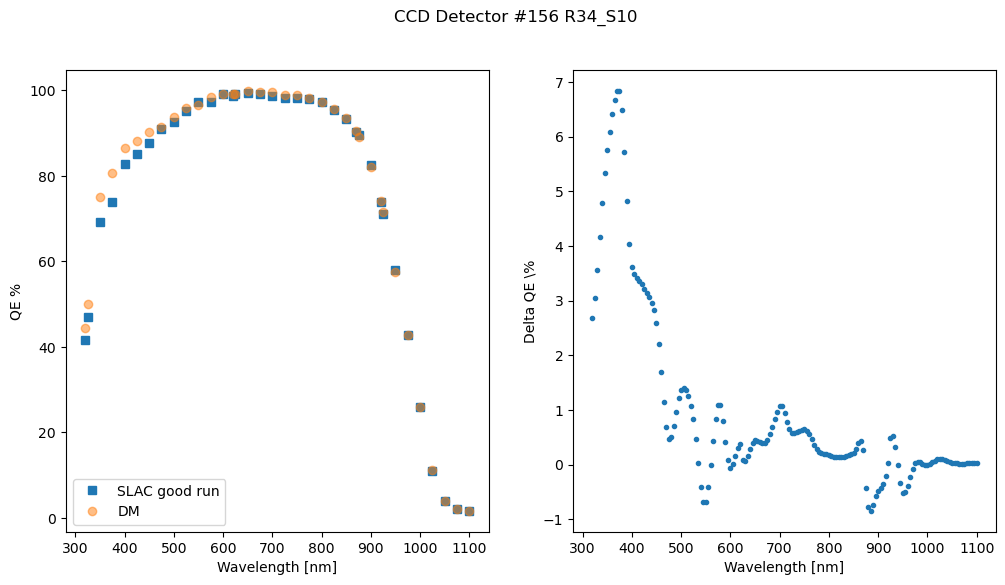

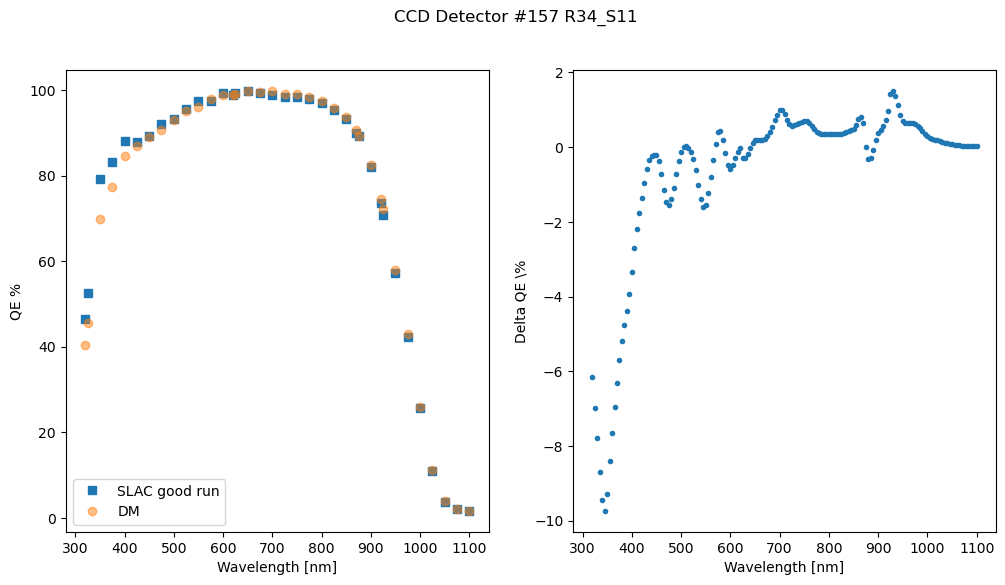

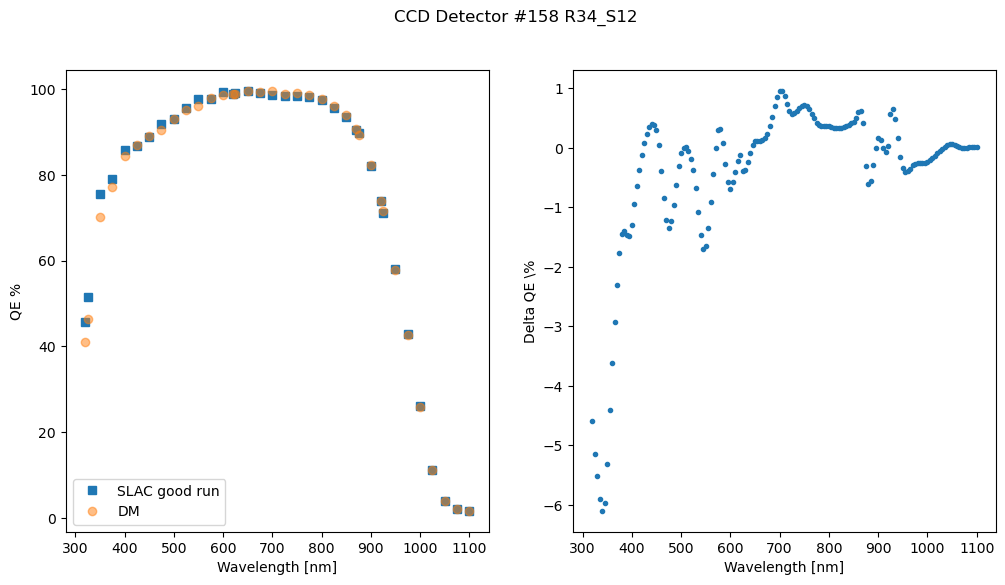

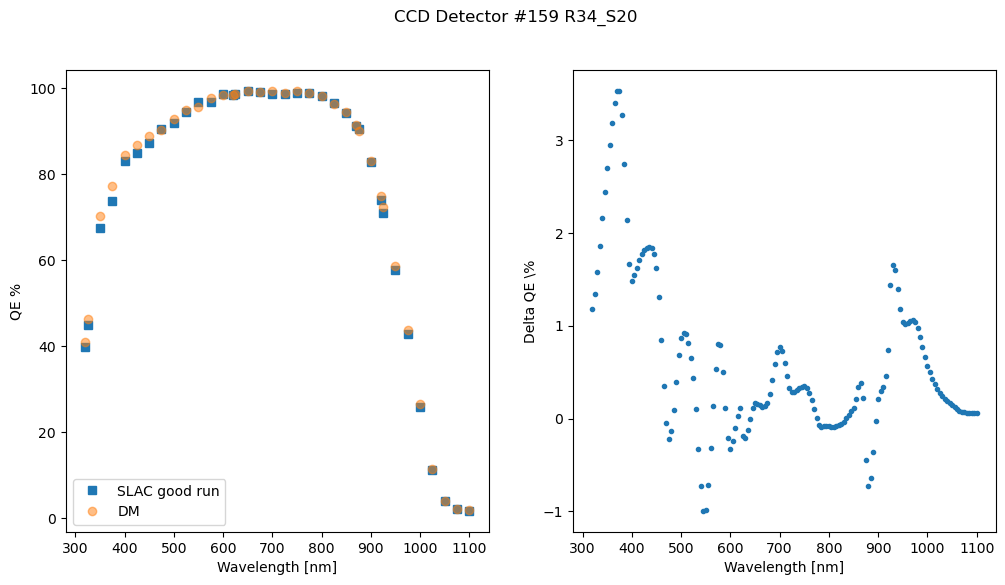

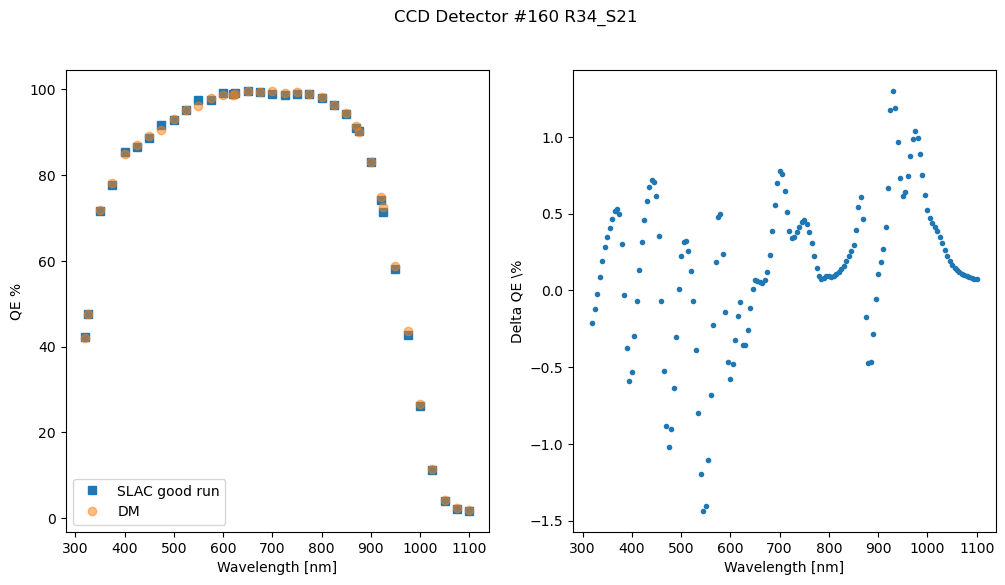

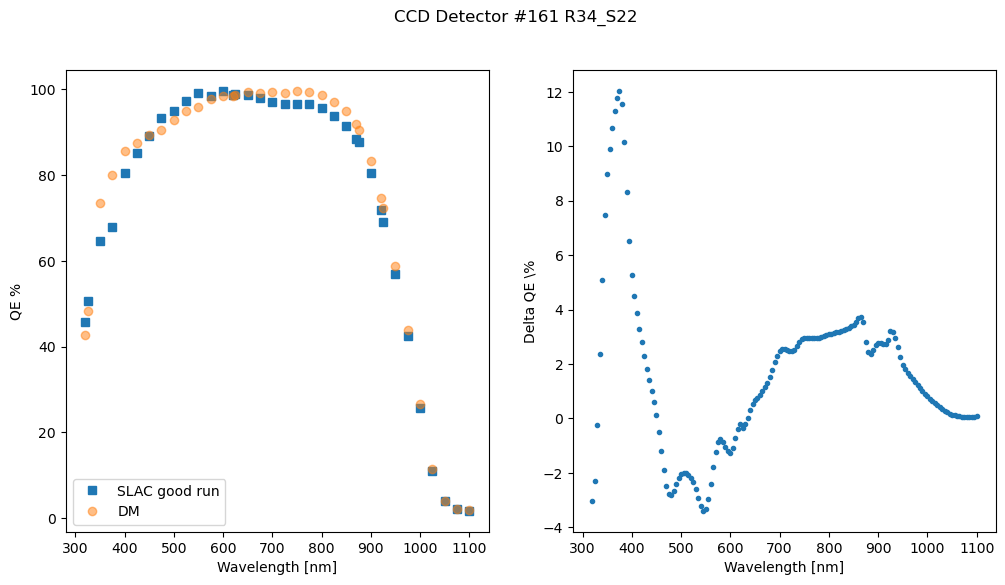

In [30]:
for idet in range(189):
    compare_ccd_qe(idet,df_slac,df_dm,label1='SLAC good run',label2='DM',plotpoints=True)  # labels are accurate only for a subset of Rafts

149 R33_S12


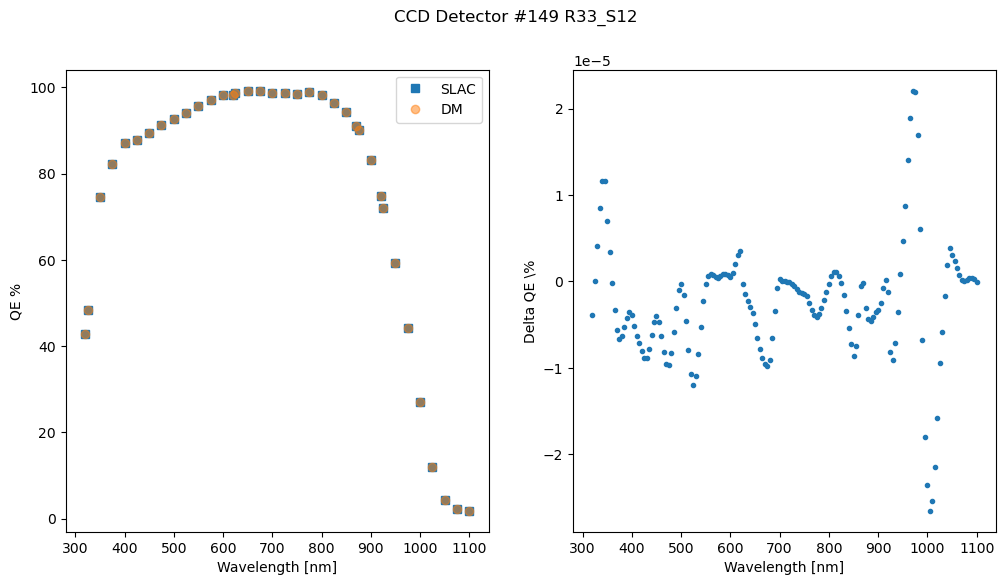

In [25]:
# R33 RTM-010 had a different good run in an earlier list, check it too
compare_ccd_qe(149,df_slac,df_dm,plotpoints=True,plot=True)

175 R42_S11


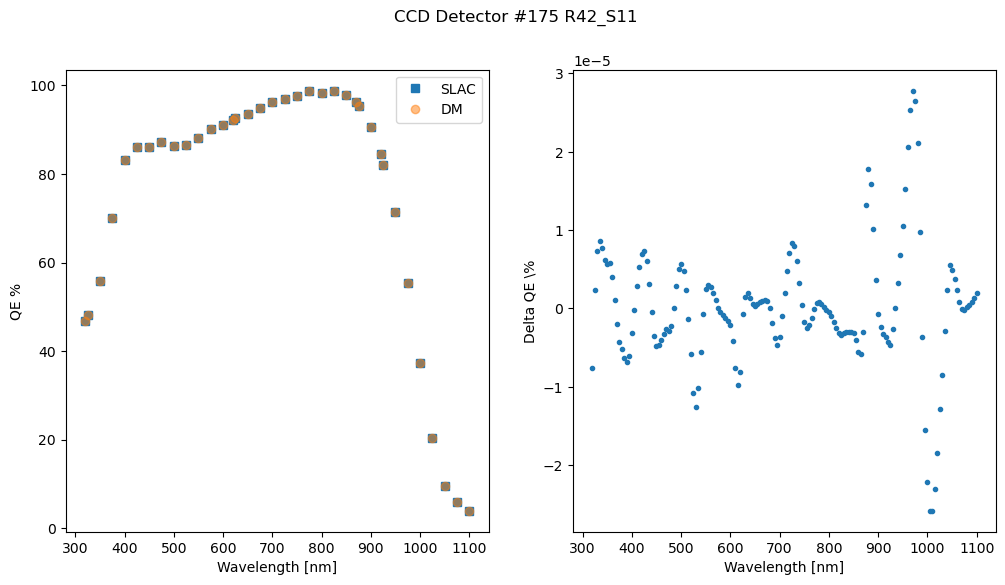

In [26]:
# R42 RTM-018 had a different good run in an earlier list, check it too
compare_ccd_qe(175,df_slac,df_dm,plotpoints=True,plot=True)

22 R03_S11


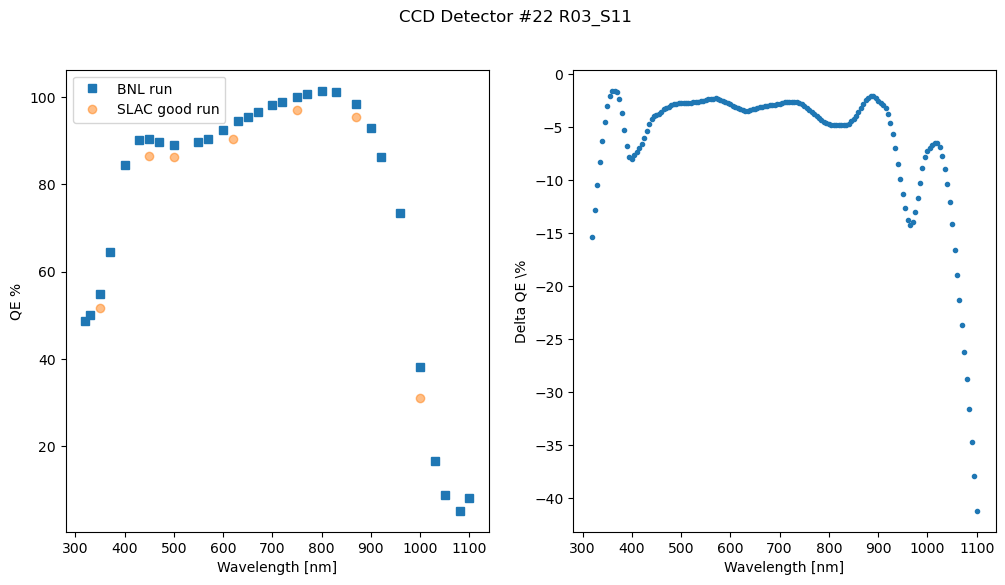

In [27]:
# R03 used a BNL run in my list
compare_ccd_qe(22,df_slac,df_dm,label1='BNL run',label2='SLAC good run',plotpoints=True,plot=True)

# get Si absoption curve, check that data past Lambda>1000 is reasonable

In [99]:
# from Steve Ritz:  model of Rajkanan et al to obtain the absorption coefficient, for T=180K, see https://www.sciencedirect.com/science/article/pii/003811017990128X
# lam in nm and T in Kelvin
# alpha is in units of cm^-1
def alpham(lam,T):
    eg=[0]*2
    ep=[0]*2
    c=[0]*2
    A=[0]*2
    c[0]=5.5
    c[1]=4.0
    A[0]=3.231e2
    A[1]=7.237e3
    ep[0]=1.827e-2
    ep[1]=5.773e-2
    beta=7.021e-4
    k=8.62e-5
    kT=k*T
    hbar=6.582e-16
    omega=2*np.pi*3e+10/(lam*1e-7)  # need lambda in cm
    eg[0]=1.1557-(beta*T**2)/(T+1108)
    eg[1]=2.5-(beta*T**2)/(T+1108)
    egd=3.2-(beta*T**2)/(T+1108)
    alpha=0.
    if (hbar*omega>egd):
        alpha=1.052e+6*(hbar*omega-egd)**0.5
    for i in range(2):
        for j in range(2):
            if ((hbar*omega+ep[i])>eg[j]):
                alpha+=c[i]*A[j]*((hbar*omega-eg[j]+ep[i])**2)/(np.exp(ep[i]/kT)-1)
            if ((hbar*omega-ep[i])>eg[j]):
                alpha+=c[i]*A[j]*((hbar*omega-eg[j]-ep[i])**2)/(1-np.exp(-ep[i]/kT))
    return alpha  

Text(0, 0.5, 'Absoption Coefficient [cm^-1]')

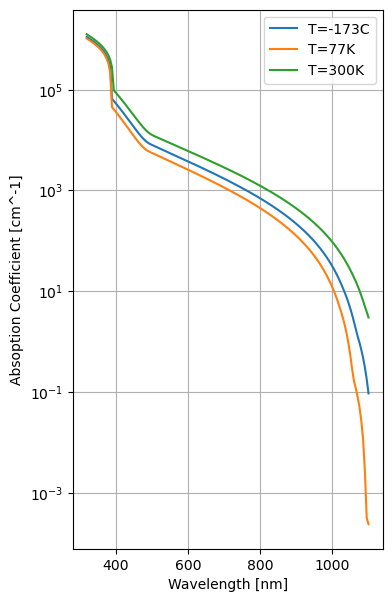

In [100]:
waves = np.arange(320.,1100.+5.,5.)
T = 273.16 - 100.0 # in Kelvin
alphas_100 = np.array([alpham(lam,T) for lam in waves])

T = 273.16 - 105.0 # in Kelvin
alphas_105 = np.array([alpham(lam,T) for lam in waves])

T = 273.16 - 95.0 # in Kelvin
alphas_95 = np.array([alpham(lam,T) for lam in waves])

T = 300.0 # in Kelvin
alphas_300 = np.array([alpham(lam,T) for lam in waves])
T = 77 # in Kelvin
alphas_77 = np.array([alpham(lam,T) for lam in waves])

f,ax = plt.subplots(1,1,figsize=(4,7))
h = ax.plot(waves,alphas_100,label="T=-173C")
h = ax.plot(waves,alphas_77,label="T=77K")
h = ax.plot(waves,alphas_300,label="T=300K")

ax.legend()
ax.grid()
ax.set_yscale('log')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Absoption Coefficient [cm^-1]')

![Si Absorption length](Images/SiAbsorption.png)

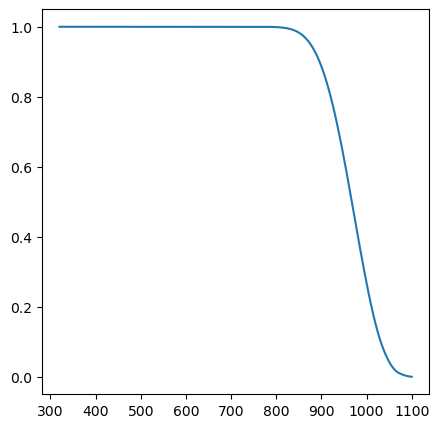

In [101]:
# convert to Probability of absoption in 100microns
L = 100.0 * 1.0e-4 # convert to cm
prob_100 = 1.0 - np.exp(-alphas_100*L)

f,ax = plt.subplots(1,1,figsize=(5,5))
h = ax.plot(waves,prob_100)

In [124]:
# normalize at a given wavelength and overplot

def redcompare_ccd_qe_raft(bay,df1,wlnorm=825.,ccdtemp=-100.0,label1='SLAC',wlrange=(320.,1100.),uselog=False):

    idetlist = get_idets(bay)
    delwl = 5.0
    waves = np.arange(wlrange[0],wlrange[1]+delwl,delwl)

    T = 273.16 + ccdtemp # in Kelvin
    alphas = np.array([alpham(lam,T) for lam in waves])
    L = 100.0 * 1.0e-4 # convert to cm
    prob_100 = 1.0 - np.exp(-alphas*L)
    
    f,ax = plt.subplots(3,3,figsize=(12,12))
    
    # ax.flatten() yields:     0 1 2
    #                          3 4 5
    #                          6 7 8 
    #
    # idetlist is in this order from S00 to S22:     6 7 8
    #                                                3 4 5
    #                                                0 1 2
    # reorder axf to match
    axf = []
    axf.append(ax[2,0])
    axf.append(ax[2,1])
    axf.append(ax[2,2])
    axf.append(ax[1,0])
    axf.append(ax[1,1])
    axf.append(ax[1,2])
    axf.append(ax[0,0])
    axf.append(ax[0,1])
    axf.append(ax[0,2])
    
    
    for i,idet in enumerate(idetlist):
        
        x1 = df1['wl'].iloc[idet]
        y1 = df1['qe'].iloc[idet]
        aninterp1 = PchipInterpolator(x1,y1,extrapolate=True)
        
        qe1 = aninterp1(waves)
        
        # normalize 
        qenorm = aninterp1(wlnorm)
        
        h = axf[i].plot(x1,y1,'s',label=label1)
        h = axf[i].plot(waves,qenorm*prob_100,'-',label='Si absorption')

        axf[i].set_xlabel('Wavelength [nm]')
        axf[i].set_ylabel('QE %')
        axf[i].set_title('Detector #%d %s'%(idet,det_names[idet]))
        axf[i].legend()
        
        if uselog:
            axf[i].set_yscale('log')
        
    f.suptitle('CCD Raft Bay %s'%(bay),size='xx-large')
    f.tight_layout()
    f.savefig('qe_comparison_raft_%s.png'%(bay))
    

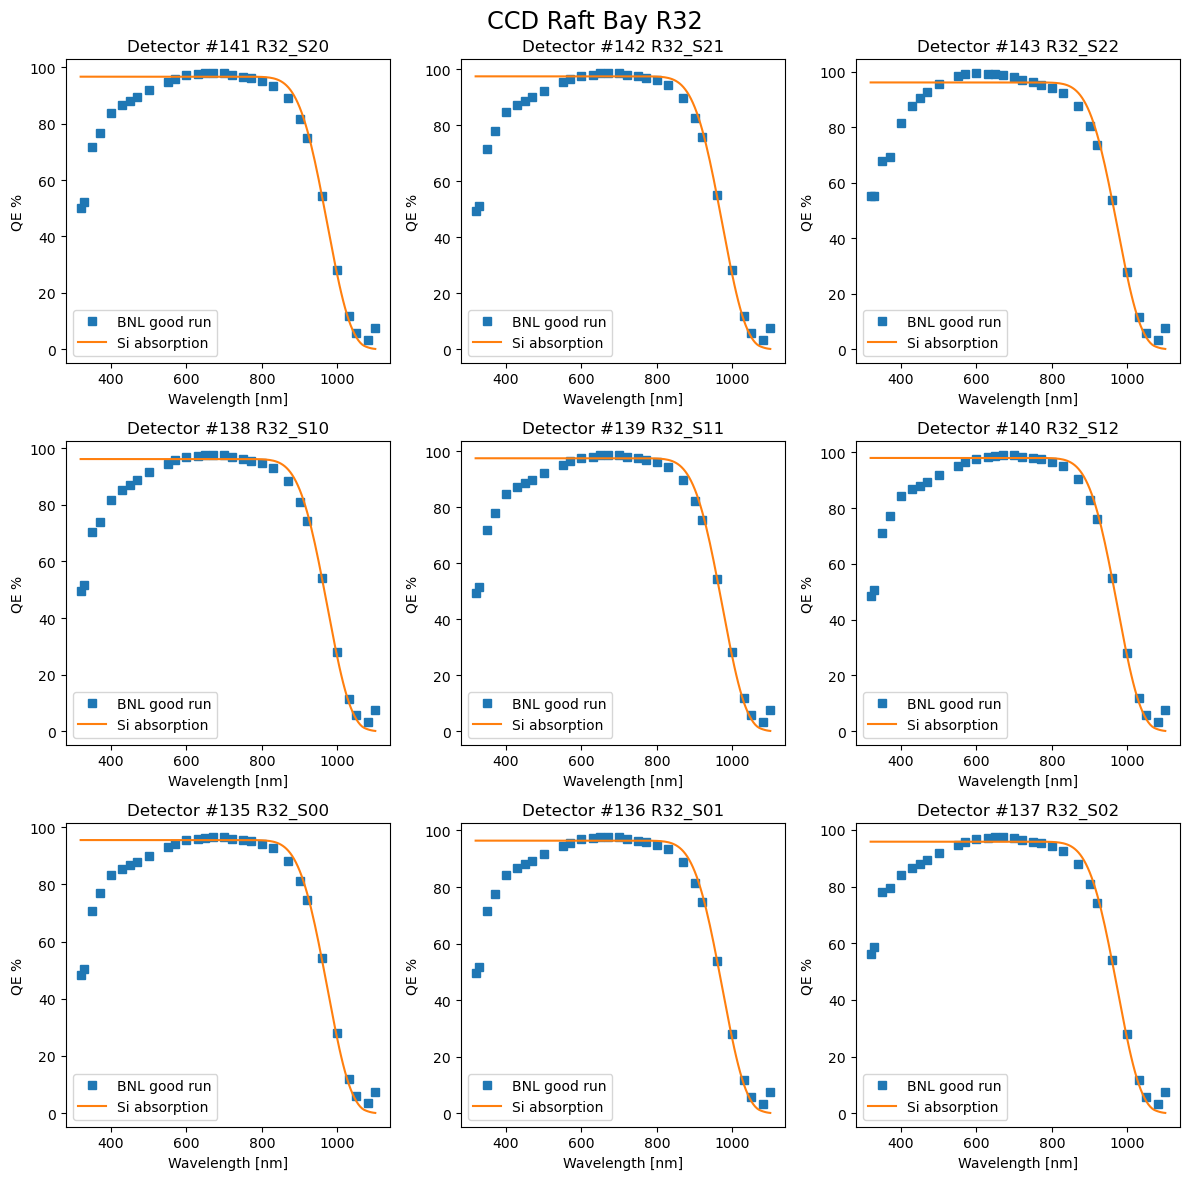

In [120]:
redcompare_ccd_qe_raft('R32',df_slac,wlnorm=750.,label1='BNL good run')

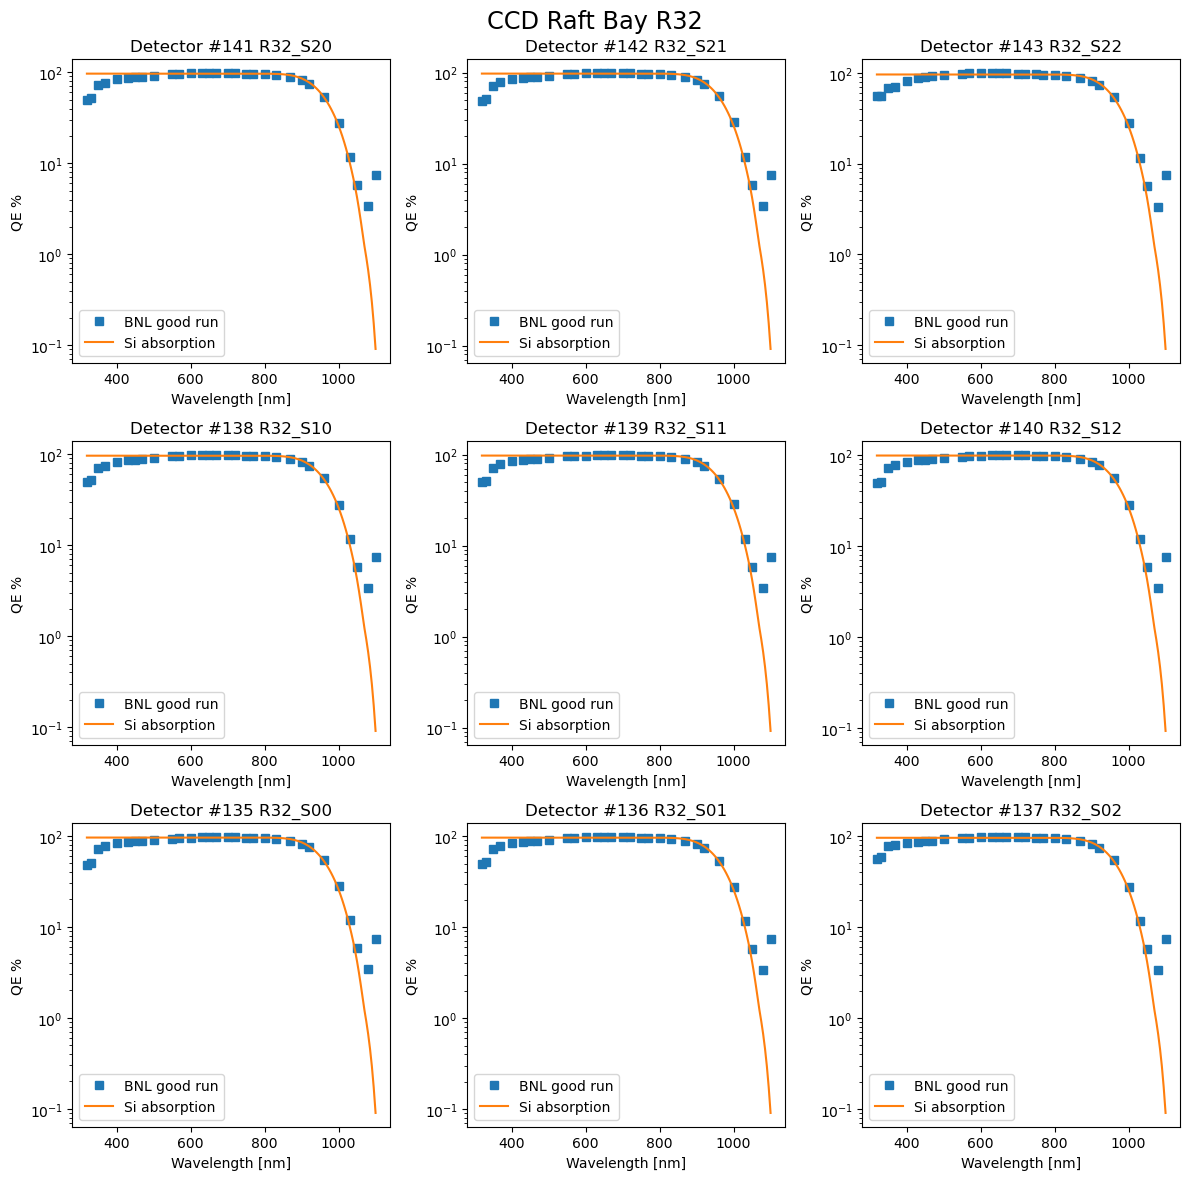

In [121]:
redcompare_ccd_qe_raft('R32',df_slac,wlnorm=750.,label1='BNL good run',uselog=True)

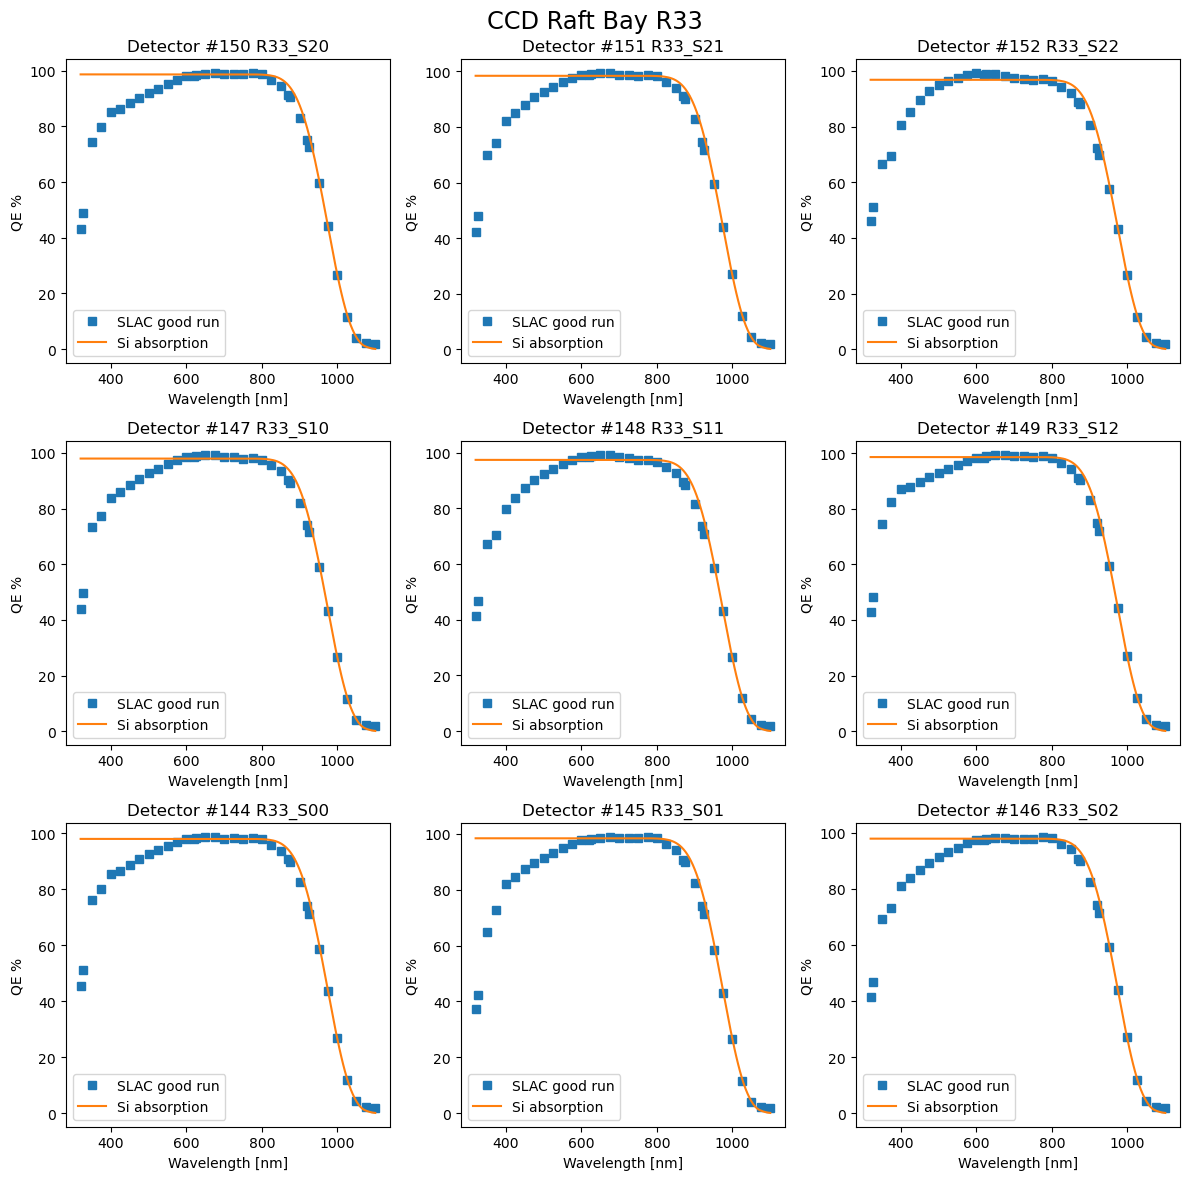

In [122]:
redcompare_ccd_qe_raft('R33',df_slac,wlnorm=750.,label1='SLAC good run')

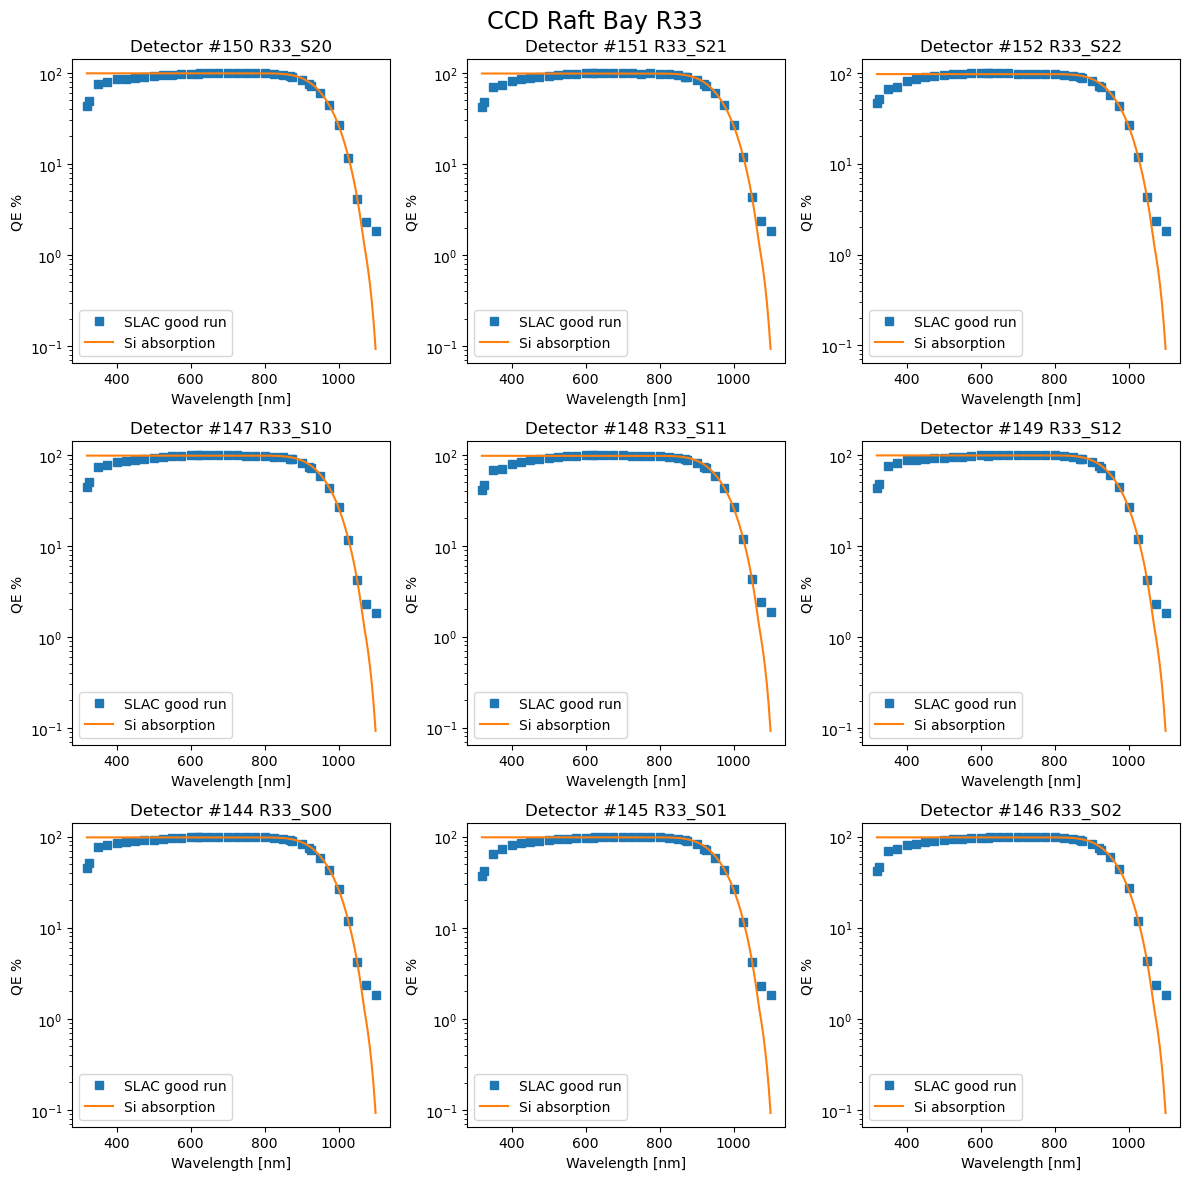

In [123]:
redcompare_ccd_qe_raft('R33',df_slac,wlnorm=750.,uselog=True,label1='SLAC good run')

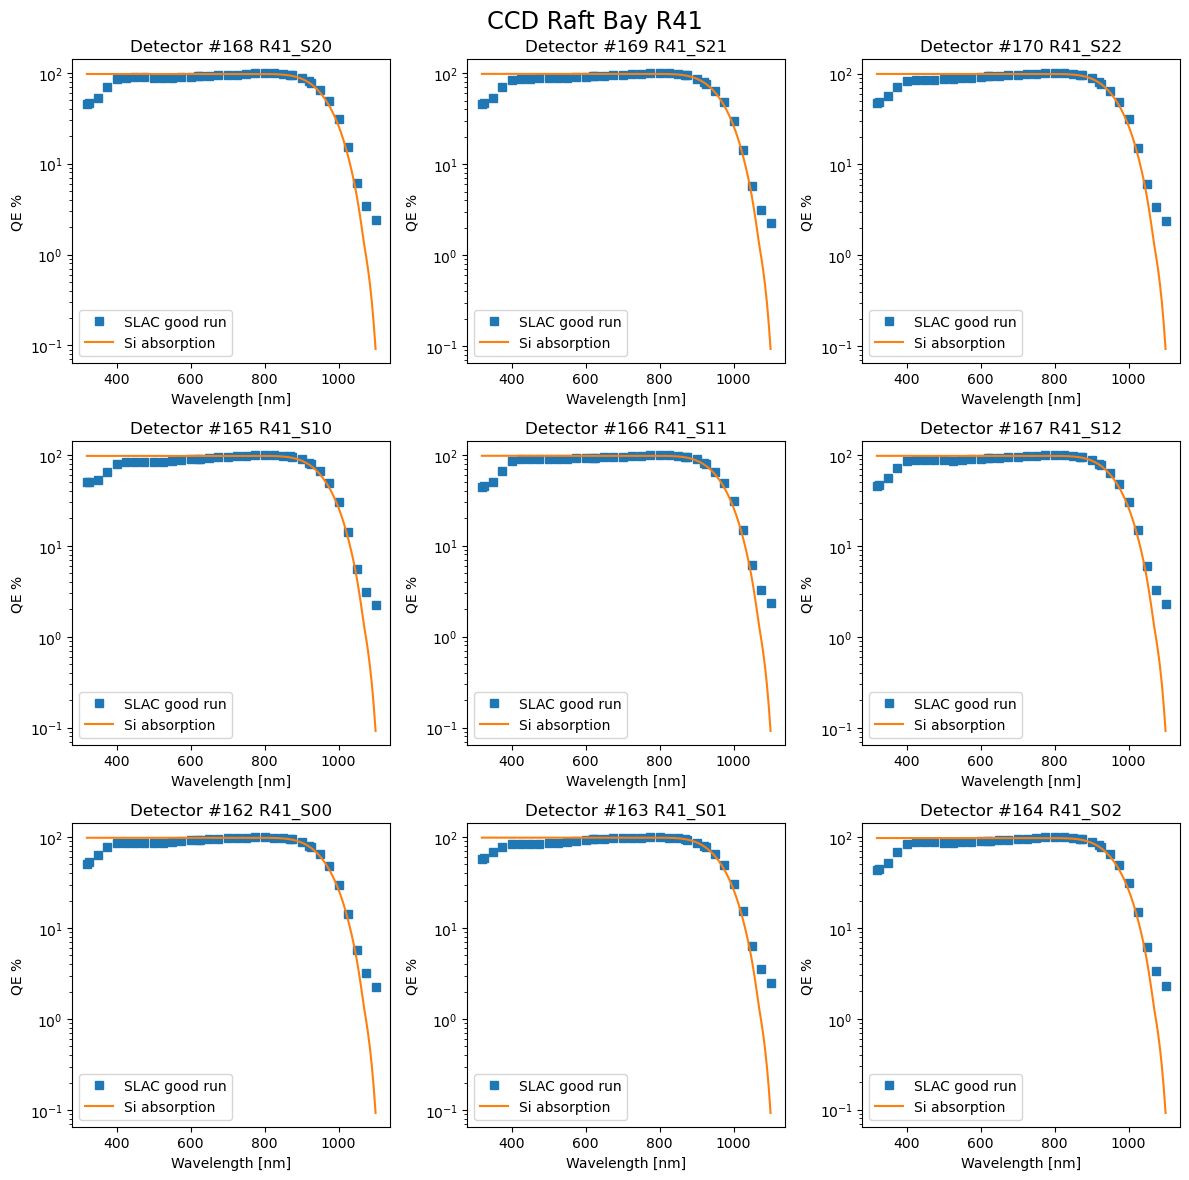

In [125]:
redcompare_ccd_qe_raft('R41',df_slac,wlnorm=750.,uselog=True,label1='SLAC good run')

# devise a correction algorithm for the highest wavelength points

## all single raft tests look to have higher QE than is physical at 1075 and 1100 nm, BNL is worse, but SLAC data also looks to be at 2% at 1075 when a max of 1% is expected

## with SLAC data: the sample ITL raft R41 shows somewhat higher QE on the red edge than expected from Si absorption, while the e2v R33 matches well up to 1050nm.  Could this be a real effect, with more reflection at the front side in ITL than e2v, and so effectively a thicker sensor?